<font size="5"><center> **Exercise 1 <br>
(Implementation of RealNVP on MNIST dataset)** </center></font>
<font size="4"><center> CS-673 <br> Introduction to Deep Generative Models </center></font>
<font size="4"><center> Sifakis Emmanouil, *1288* </center></font>

---

↓ Imports ↓

In [26]:
# # Comment the following lines if you're not in colab:
# from google.colab import drive
# drive.mount('/content/drive')
# # If you're in colab, cd to your own working directory here:
# %cd ..//..//content//drive//MyDrive//Colab-Notebooks//HY-673-Tutorials//Tutorial-8

In [1]:
import numpy as np
import torch as tc
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.distributions import Uniform
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import os

seed = 42
tc.manual_seed(42)
tc.set_default_dtype(tc.float32)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"Using --> {device}")

Using --> cuda


<font size="3">The following code is based on the core concepts presented in Tutorial 7 of the course. This tutorial introduced fundamental techniques for building normalizing flow models, with a particular focus on the NICE model. The primary modifications in this code center around the `RealNVPCouplingLayer` class, as the RealNVP model differs significantly from NICE. 

In RealNVP, the coupling layers include both scaling and translation transformations, making the model more expressive compared to NICE, which only uses translation transformations. These changes are crucial for improving the model's ability to learn complex data distributions. The rest of the code structure, including the training loop, data loading, and checkpointing, follows the structure laid out in Tutorial 7, ensuring consistency with the course material while introducing these advanced concepts.

### Mapping of NICE vs RealNVP

#### NICE Model

Forward Transformation:
$$
\begin{pmatrix}
y_A \\
y_B
\end{pmatrix}
=
\begin{pmatrix}
x_A \\
x_B + m_\theta(x_A)
\end{pmatrix}
$$

Inverse Transformation:
$$
\begin{pmatrix}
x_A \\
x_B
\end{pmatrix}
=
\begin{pmatrix}
y_A \\
y_B - m_\theta(y_A)
\end{pmatrix}
$$

where $\{x_A, x_B\}$ and $\{y_A, y_B\}$ are partitions of the data vectors, and $m_\theta(\cdot)$ is a neural network with parameters $\theta$.

#### RealNVP Model

Forward Transformation:
$$
\begin{pmatrix}
y_A \\
y_B
\end{pmatrix}
=
\begin{pmatrix}
x_A \\
x_B \odot \exp(s_\theta(x_A)) + t_\theta(x_A)
\end{pmatrix}
$$

Inverse Transformation:
$$
\begin{pmatrix}
x_A \\
x_B
\end{pmatrix}
=
\begin{pmatrix}
y_A \\
(y_B - t_\theta(y_A)) \odot \exp(-s_\theta(y_A))
\end{pmatrix}
$$

where $\{x_A, x_B\}$ and $\{y_A, y_B\}$ are partitions of the data vectors, $\odot$ denotes element-wise product, and both $s_\theta(\cdot)$ and $t_\theta(\cdot)$ are neural networks with parameters $\theta$.

$s_\theta(\cdot)$ and $t_\theta(\cdot)$ are described as 'scale' and 'translation' elements accordingly.


→ (a): Implement RealNVP model

↓ CouplingLayer Class ↓

In [2]:
# Generates an alternating binary mask of given dimension
def get_mask(dim, orientation=True):
    return ((1 - tc.arange(dim) % 2) ^ orientation).float()

class RealNVPCouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask, n_layers=4):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.odd_mask = mask
        self.even_mask = 1 - self.odd_mask

        self.scale_net = self._build_subnet(input_dim, hidden_dim, n_layers)
        self.translation_net = self._build_subnet(input_dim, hidden_dim, n_layers)

    def _build_subnet(self, input_dim, hidden_dim, n_layers):
        modules = [nn.Linear(input_dim, hidden_dim), nn.LeakyReLU(0.15)]

        for _ in range(n_layers - 2):
            modules.append(nn.Linear(hidden_dim, hidden_dim))
            modules.append(nn.ReLU(0.15))
        modules.append(nn.Linear(hidden_dim, input_dim))

        return nn.Sequential(*modules)

    def forward(self, x):
        x1 = self.odd_mask * x
        x2 = self.even_mask * x

        # bound the output of the scale network within a range of [−1,1]
        scale = tc.exp(tc.tanh(self.scale_net(x1))) # αθ(x1) 
        
        # even_mask is applied to translation component to ensure transformations
        # are applied to masked elements. scale inherently applies to masked input by multiplication
        translation = self.translation_net(x1) * self.even_mask # mθ(x1)

        y1 = x1
        y2 = x2 * scale + translation

        return y1 + y2

    def inverse(self, y):
        y1 = self.odd_mask * y
        y2 = self.even_mask * y

        scale = tc.exp(-tc.tanh(self.scale_net(y1))) # αθ(x1)
        translation = self.translation_net(y1) * self.even_mask # mθ(x1)

        x1 = y1
        x2 = (y2 - translation) * scale

        return x1 + x2

# The ScalingLayer applies a global scaling transformation to the data 
# and computes the log-determinant of the Jacobian, used to calculate 
# the log-likelihood. It is used separately from the coupling layers.
class ScalingLayer(nn.Module):
    def __init__(self, inpt_dim):
        super().__init__()
        self.log_scale_vector = nn.Parameter(tc.zeros(1, inpt_dim, requires_grad=True))

    def forward(self, x):
        log_det_jacobian = tc.sum(self.log_scale_vector)
        scaled_x = tc.exp(self.log_scale_vector) * x
        return scaled_x, log_det_jacobian

    def inverse(self, x):
        return tc.exp(-self.log_scale_vector) * x

↓ RealNVP ↓

In [3]:
# Distribution base class for log probability and sampling
class Distribution(ABC):
    @abstractmethod
    def log_prob(self, x):
        pass

    @abstractmethod
    def sample(self, size):
        pass

# LogisticDistribution class for computing log prob and sampling
class LogisticDistribution(Distribution):
    def __init__(self):
        super().__init__()
        self.uniform_dist = Uniform(tc.tensor([0.0]), tc.tensor([1.0]))

    def log_prob(self, x):
        return -(F.softplus(x) + F.softplus(-x))

    def sample(self, size):
        z = self.uniform_dist.sample(size)
        return tc.log(z) - tc.log(1. - z)

# RealNVP class implementing the main model:
class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim=1000, n_coupling_layers=3, n_layers=6):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_coupling_layers = n_coupling_layers
        self.num_layers = n_layers
        self.prior = LogisticDistribution()

        masks = [
            get_mask(input_dim, orientation=(i % 2 == 0)).to(device)
            for i in range(n_coupling_layers)
        ]

        self.coupling_layers = nn.ModuleList([
            RealNVPCouplingLayer(
                input_dim=input_dim,
                hidden_dim=hidden_dim,
                mask=masks[i],
                n_layers=n_layers
            )
            for i in range(n_coupling_layers)
        ])
        self.scaling_layer = ScalingLayer(inpt_dim=input_dim)

    # Applies coupling layers and scaling layer, computes log likelihood
    def forward(self, x):
        y = x
        for i in range(len(self.coupling_layers)):
            y = self.coupling_layers[i](y)
        y, log_det_jacobian = self.scaling_layer(y)
        log_likel = tc.sum(self.prior.log_prob(y), dim=1) + log_det_jacobian
        return y, log_likel

    # Applies inverse scaling and coupling layers to reconstruct input
    def inverse(self, y):
        x = y
        x = self.scaling_layer.inverse(x)
        for i in reversed(range(len(self.coupling_layers))):
            x = self.coupling_layers[i].inverse(x)
        return x

    # Samples from the prior and generates corresponding data
    def sample(self, num_samples):
        y = self.prior.sample([num_samples, self.input_dim]).view(num_samples, self.input_dim).to(device)
        return self.inverse(y)

↓ Dequantize and Scale images ↓

In [4]:
# add uniform noise to dequantize images and scales them to a specified range, 
# clamping the values between 0 and 1.
class DequantizeAndScale(tc.nn.Module):
    def __init__(self, scale_range=(0, 1)):
        super().__init__()
        self.min_val, self.max_val = scale_range

    def forward(self, img):
        img += tc.rand_like(img) / 256.0
        img *= (self.max_val - self.min_val) + self.min_val
        return img.clamp(0, 1)

↓ Train the RealNVP model ↓

In [5]:
def train_realnvp(model, input_dim, epochs, train_loader, lr, betas, eps, 
                  checkpoint_folder = 'checkpoints', checkpoint_name = 'best_model.pth'):

    os.makedirs(checkpoint_folder, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_folder, checkpoint_name)

    model.train()
    optimizer = Adam(params=model.parameters(), lr=lr, betas=betas, eps=eps)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    losses_ = np.zeros(epochs)
    best_loss = float('inf') # for the saving

    for epoch in range(epochs):
        model.train()
        tot_mean_nll = 0.0

        for batch_id, (x, _) in tqdm(enumerate(train_loader), total=len(train_loader)):
            # Zero gradients:
            model.zero_grad()
            # Move to device and flatten:
            x = x.to(device).view(-1, input_dim)
            # Call model:
            _, log_likelihood = model(x)
            # Compute mean NLL loss:
            loss = -tc.mean(log_likelihood)
            # Backpropagate:
            loss.backward()
            # Gradient clipping:
            tc.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
            # Update weights:
            optimizer.step()
            # Add loss:
            tot_mean_nll += loss.item()

        # Take the mean over each epoch and print:
        mean_nll = tot_mean_nll / len(train_loader)
        losses_[epoch] = mean_nll
        print(f'Epoch {epoch+1}/{epochs} | Mean NLL (Loss): {mean_nll:.4f}')

        ######### SAVE BEST MODEL #########
        if mean_nll < best_loss:
            best_loss = mean_nll
            best_epoch = epoch + 1
            tc.save({
                'epoch': best_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, checkpoint_path)
        ###################################
        
        if (epoch + 1) % 5 == 0:
            sample_model(model, n_samples=12, title=f"Epoch {epoch + 1}")

        scheduler.step()  # Stepping the scheduler at the end of each epoch

    return losses_

# Generates and visualizes samples from the trained model
def sample_model(model, n_samples=12, title="None"):
    model.eval()
    x_hat = model.sample(n_samples)
    x_hat = x_hat.cpu().detach().numpy().reshape(n_samples, 28, 28)
    n_rows, n_cols = 2, 6  # 2 rows and 6 columns
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(2*n_cols, 2*n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, ax in enumerate(axs.flat[:n_samples]):
        ax.imshow(x_hat[i], cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

→ (b): Train RealNVP for 5 and 10 coupling-layers

100%|██████████| 469/469 [00:20<00:00, 22.89it/s]


Epoch 1/100 | Mean NLL (Loss): 910.3741


100%|██████████| 469/469 [00:20<00:00, 22.90it/s]


Epoch 2/100 | Mean NLL (Loss): 542.6737


100%|██████████| 469/469 [00:20<00:00, 23.01it/s]


Epoch 3/100 | Mean NLL (Loss): 176.4728


100%|██████████| 469/469 [00:20<00:00, 22.92it/s]


Epoch 4/100 | Mean NLL (Loss): -189.1043


100%|██████████| 469/469 [00:20<00:00, 22.99it/s]


Epoch 5/100 | Mean NLL (Loss): -553.6207


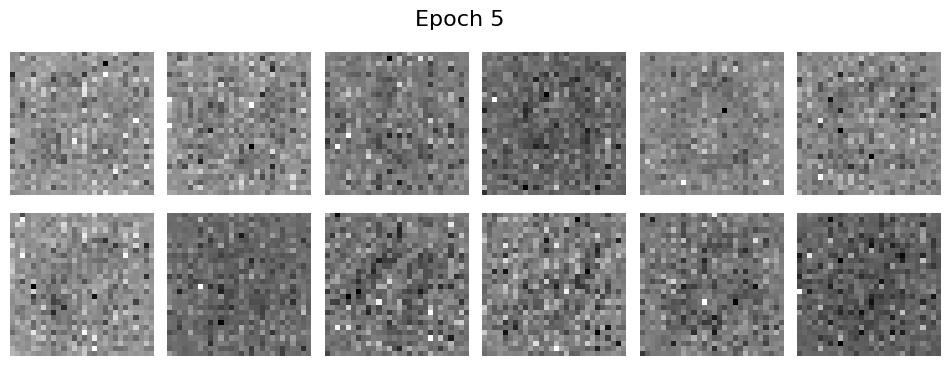

100%|██████████| 469/469 [00:20<00:00, 22.90it/s]


Epoch 6/100 | Mean NLL (Loss): -827.0506


100%|██████████| 469/469 [00:20<00:00, 22.87it/s]


Epoch 7/100 | Mean NLL (Loss): -1007.6258


100%|██████████| 469/469 [00:20<00:00, 22.87it/s]


Epoch 8/100 | Mean NLL (Loss): -1186.4054


100%|██████████| 469/469 [00:20<00:00, 22.87it/s]


Epoch 9/100 | Mean NLL (Loss): -1362.3897


100%|██████████| 469/469 [00:20<00:00, 23.01it/s]


Epoch 10/100 | Mean NLL (Loss): -1533.3837


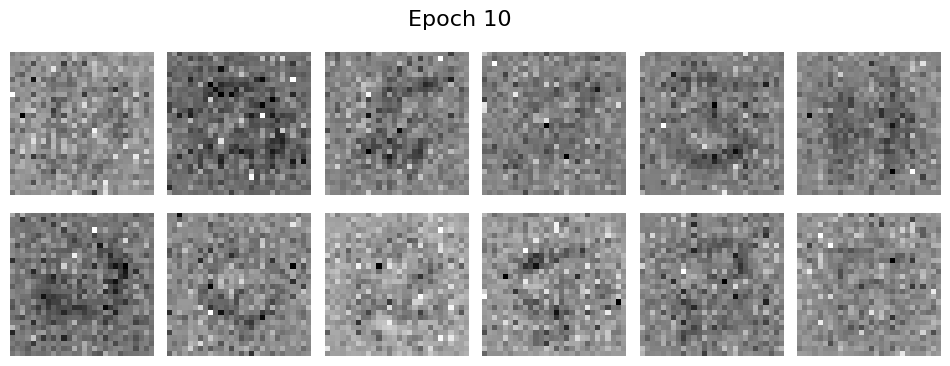

100%|██████████| 469/469 [00:20<00:00, 22.81it/s]


Epoch 11/100 | Mean NLL (Loss): -1662.6998


100%|██████████| 469/469 [00:20<00:00, 22.81it/s]


Epoch 12/100 | Mean NLL (Loss): -1744.7594


100%|██████████| 469/469 [00:20<00:00, 23.05it/s]


Epoch 13/100 | Mean NLL (Loss): -1823.7788


100%|██████████| 469/469 [00:20<00:00, 22.76it/s]


Epoch 14/100 | Mean NLL (Loss): -1899.8138


100%|██████████| 469/469 [00:20<00:00, 22.87it/s]


Epoch 15/100 | Mean NLL (Loss): -1972.3818


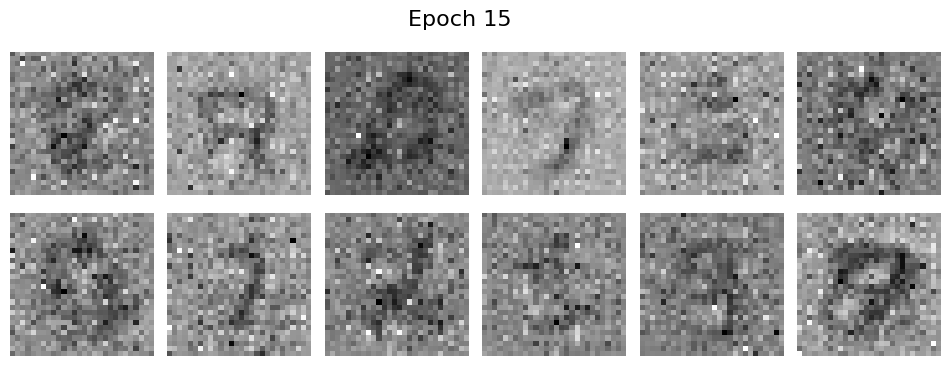

100%|██████████| 469/469 [00:20<00:00, 22.80it/s]


Epoch 16/100 | Mean NLL (Loss): -2032.3321


100%|██████████| 469/469 [00:20<00:00, 22.92it/s]


Epoch 17/100 | Mean NLL (Loss): -2068.0295


100%|██████████| 469/469 [00:20<00:00, 22.83it/s]


Epoch 18/100 | Mean NLL (Loss): -2102.0227


100%|██████████| 469/469 [00:20<00:00, 23.10it/s]


Epoch 19/100 | Mean NLL (Loss): -2134.9883


100%|██████████| 469/469 [00:19<00:00, 23.49it/s]


Epoch 20/100 | Mean NLL (Loss): -2167.3718


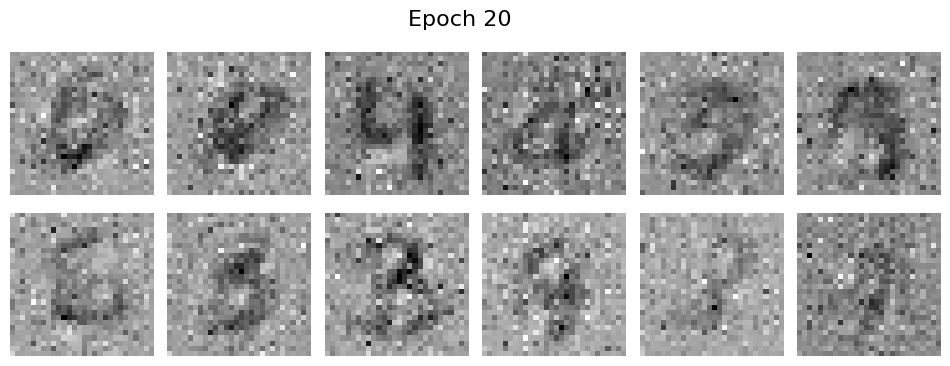

100%|██████████| 469/469 [00:20<00:00, 22.97it/s]


Epoch 21/100 | Mean NLL (Loss): -2196.0347


100%|██████████| 469/469 [00:19<00:00, 23.72it/s]


Epoch 22/100 | Mean NLL (Loss): -2213.0882


100%|██████████| 469/469 [00:19<00:00, 23.70it/s]


Epoch 23/100 | Mean NLL (Loss): -2229.4724


100%|██████████| 469/469 [00:19<00:00, 23.68it/s]


Epoch 24/100 | Mean NLL (Loss): -2245.4940


100%|██████████| 469/469 [00:19<00:00, 23.55it/s]


Epoch 25/100 | Mean NLL (Loss): -2261.3333


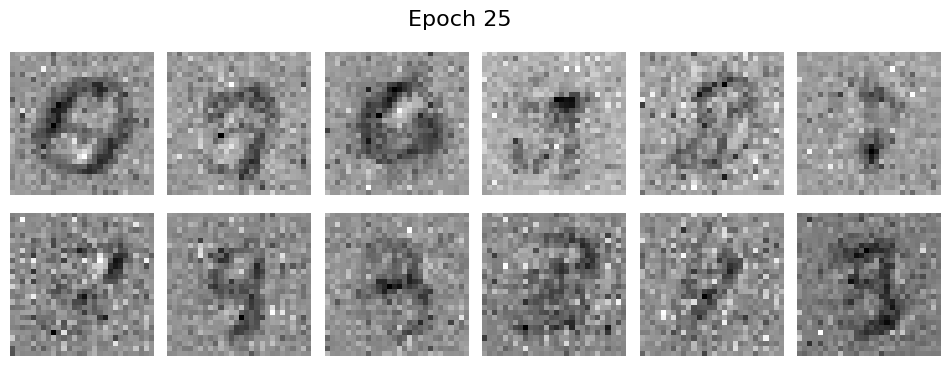

100%|██████████| 469/469 [00:19<00:00, 23.49it/s]


Epoch 26/100 | Mean NLL (Loss): -2275.4393


100%|██████████| 469/469 [00:20<00:00, 23.37it/s]


Epoch 27/100 | Mean NLL (Loss): -2283.9993


100%|██████████| 469/469 [00:20<00:00, 22.97it/s]


Epoch 28/100 | Mean NLL (Loss): -2292.3833


100%|██████████| 469/469 [00:20<00:00, 22.84it/s]


Epoch 29/100 | Mean NLL (Loss): -2300.6383


100%|██████████| 469/469 [00:20<00:00, 22.92it/s]


Epoch 30/100 | Mean NLL (Loss): -2308.6637


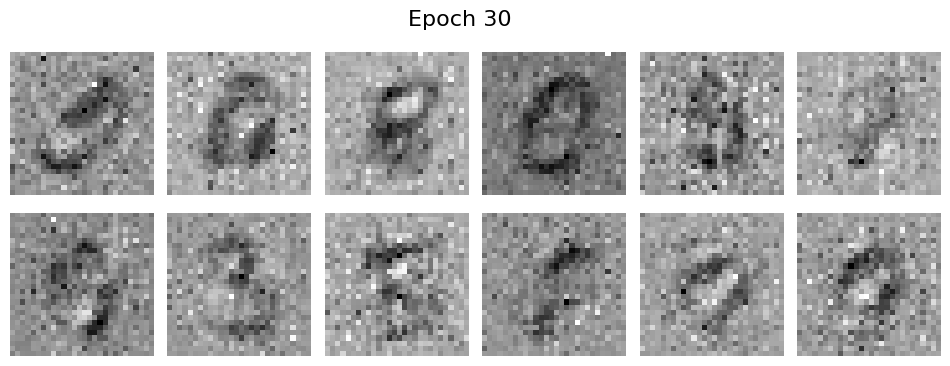

100%|██████████| 469/469 [00:20<00:00, 22.86it/s]


Epoch 31/100 | Mean NLL (Loss): -2315.6689


100%|██████████| 469/469 [00:20<00:00, 22.73it/s]


Epoch 32/100 | Mean NLL (Loss): -2320.0469


100%|██████████| 469/469 [00:20<00:00, 22.88it/s]


Epoch 33/100 | Mean NLL (Loss): -2324.3668


100%|██████████| 469/469 [00:19<00:00, 23.91it/s]


Epoch 34/100 | Mean NLL (Loss): -2328.6376


100%|██████████| 469/469 [00:19<00:00, 24.30it/s]


Epoch 35/100 | Mean NLL (Loss): -2332.8657


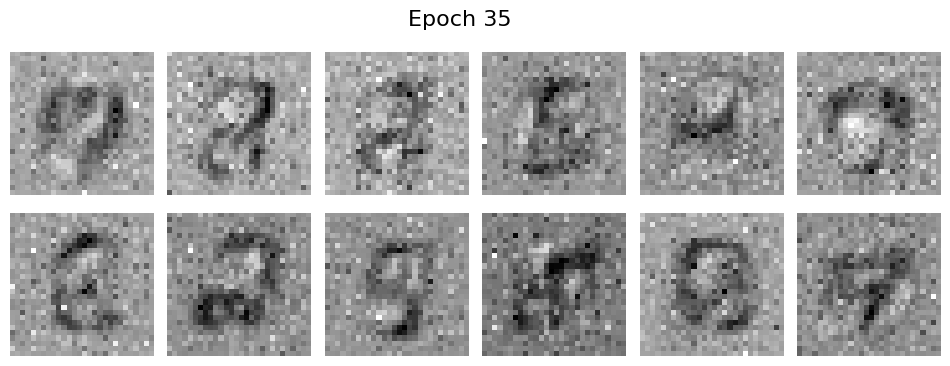

100%|██████████| 469/469 [00:20<00:00, 23.00it/s]


Epoch 36/100 | Mean NLL (Loss): -2336.3124


100%|██████████| 469/469 [00:20<00:00, 22.96it/s]


Epoch 37/100 | Mean NLL (Loss): -2338.5053


100%|██████████| 469/469 [00:20<00:00, 22.96it/s]


Epoch 38/100 | Mean NLL (Loss): -2340.6855


100%|██████████| 469/469 [00:20<00:00, 22.91it/s]


Epoch 39/100 | Mean NLL (Loss): -2342.8606


100%|██████████| 469/469 [00:20<00:00, 22.87it/s]


Epoch 40/100 | Mean NLL (Loss): -2345.0198


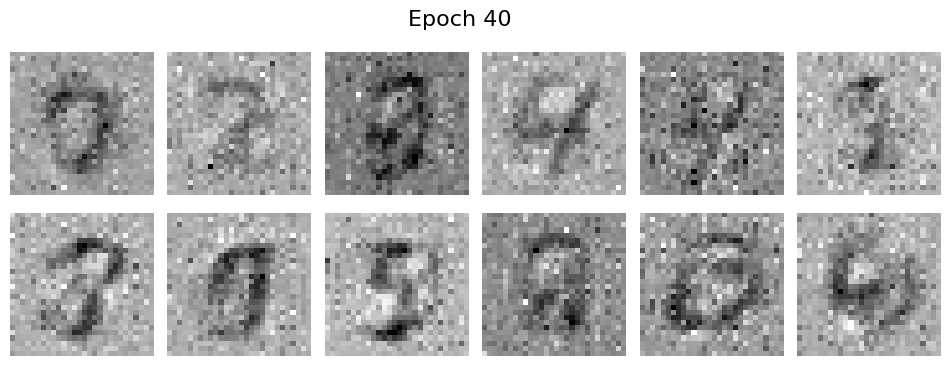

100%|██████████| 469/469 [00:20<00:00, 23.20it/s]


Epoch 41/100 | Mean NLL (Loss): -2346.7297


100%|██████████| 469/469 [00:19<00:00, 23.69it/s]


Epoch 42/100 | Mean NLL (Loss): -2347.8313


100%|██████████| 469/469 [00:19<00:00, 23.63it/s]


Epoch 43/100 | Mean NLL (Loss): -2348.9141


100%|██████████| 469/469 [00:20<00:00, 23.37it/s]


Epoch 44/100 | Mean NLL (Loss): -2350.0121


100%|██████████| 469/469 [00:20<00:00, 22.79it/s]


Epoch 45/100 | Mean NLL (Loss): -2351.0925


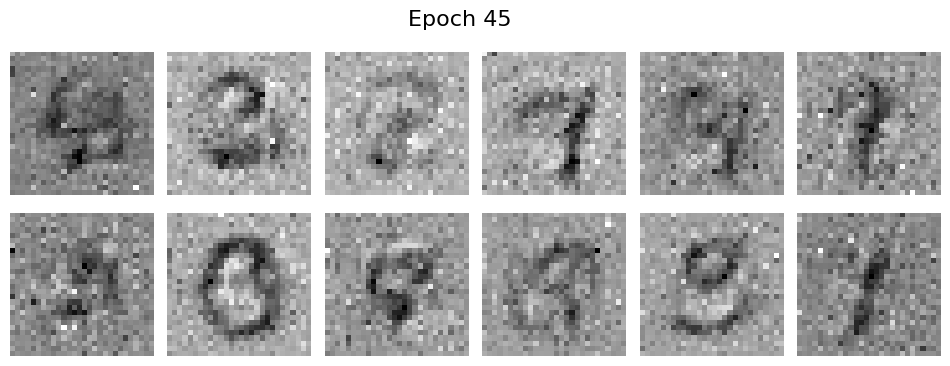

100%|██████████| 469/469 [00:20<00:00, 22.94it/s]


Epoch 46/100 | Mean NLL (Loss): -2351.9549


100%|██████████| 469/469 [00:20<00:00, 22.91it/s]


Epoch 47/100 | Mean NLL (Loss): -2352.4866


100%|██████████| 469/469 [00:20<00:00, 22.81it/s]


Epoch 48/100 | Mean NLL (Loss): -2353.0385


100%|██████████| 469/469 [00:20<00:00, 22.86it/s]


Epoch 49/100 | Mean NLL (Loss): -2353.5804


100%|██████████| 469/469 [00:20<00:00, 22.83it/s]


Epoch 50/100 | Mean NLL (Loss): -2354.1288


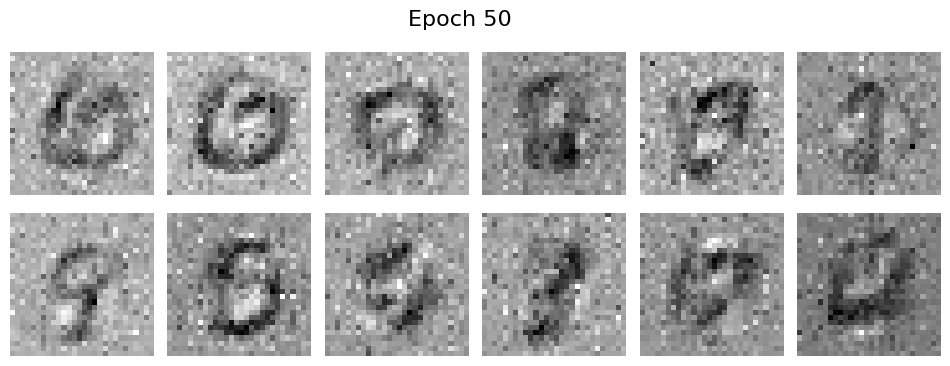

100%|██████████| 469/469 [00:20<00:00, 22.78it/s]


Epoch 51/100 | Mean NLL (Loss): -2354.5542


100%|██████████| 469/469 [00:20<00:00, 22.87it/s]


Epoch 52/100 | Mean NLL (Loss): -2354.8249


100%|██████████| 469/469 [00:20<00:00, 22.89it/s]


Epoch 53/100 | Mean NLL (Loss): -2355.1012


100%|██████████| 469/469 [00:20<00:00, 23.03it/s]


Epoch 54/100 | Mean NLL (Loss): -2355.3655


100%|██████████| 469/469 [00:20<00:00, 22.93it/s]


Epoch 55/100 | Mean NLL (Loss): -2355.6395


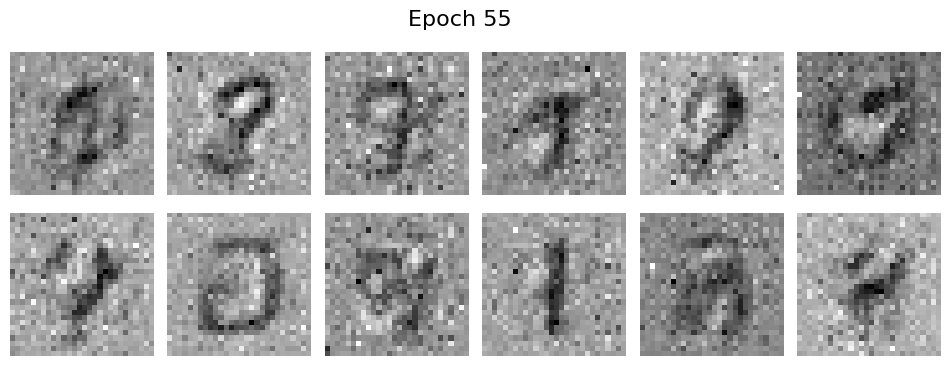

100%|██████████| 469/469 [00:20<00:00, 22.80it/s]


Epoch 56/100 | Mean NLL (Loss): -2355.8565


100%|██████████| 469/469 [00:20<00:00, 22.77it/s]


Epoch 57/100 | Mean NLL (Loss): -2355.9829


100%|██████████| 469/469 [00:20<00:00, 22.83it/s]


Epoch 58/100 | Mean NLL (Loss): -2356.1178


100%|██████████| 469/469 [00:20<00:00, 22.80it/s]


Epoch 59/100 | Mean NLL (Loss): -2356.2551


100%|██████████| 469/469 [00:20<00:00, 23.33it/s]


Epoch 60/100 | Mean NLL (Loss): -2356.3837


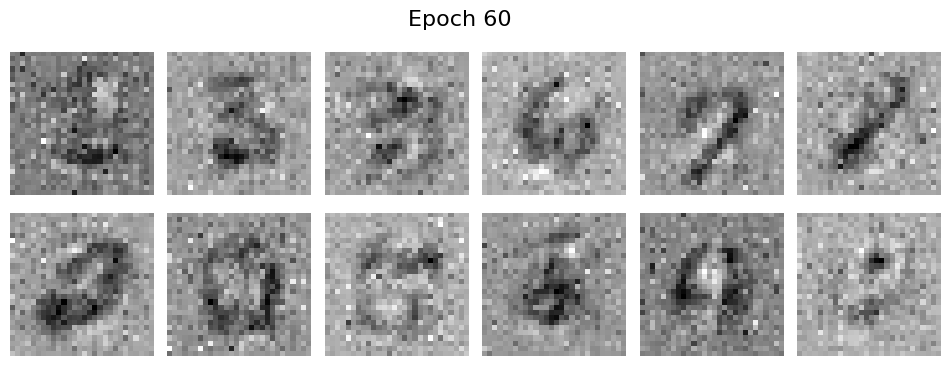

100%|██████████| 469/469 [00:19<00:00, 23.64it/s]


Epoch 61/100 | Mean NLL (Loss): -2356.4956


100%|██████████| 469/469 [00:19<00:00, 23.66it/s]


Epoch 62/100 | Mean NLL (Loss): -2356.5645


100%|██████████| 469/469 [00:19<00:00, 23.62it/s]


Epoch 63/100 | Mean NLL (Loss): -2356.6359


100%|██████████| 469/469 [00:19<00:00, 23.68it/s]


Epoch 64/100 | Mean NLL (Loss): -2356.7119


100%|██████████| 469/469 [00:19<00:00, 23.62it/s]


Epoch 65/100 | Mean NLL (Loss): -2356.7850


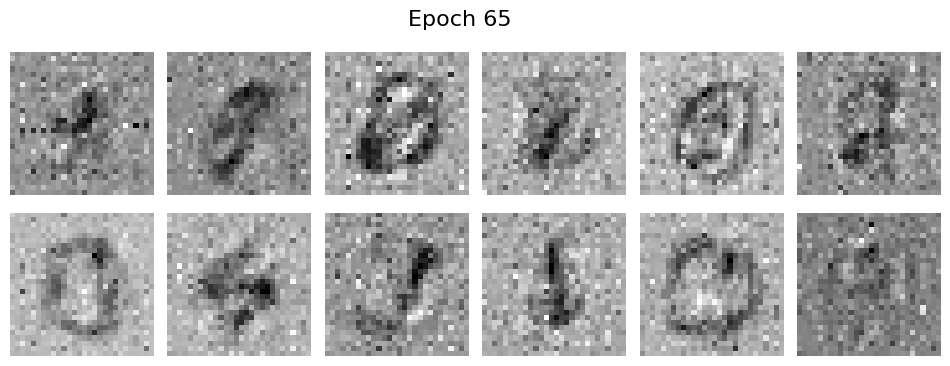

100%|██████████| 469/469 [00:19<00:00, 23.60it/s]


Epoch 66/100 | Mean NLL (Loss): -2356.8259


100%|██████████| 469/469 [00:19<00:00, 23.57it/s]


Epoch 67/100 | Mean NLL (Loss): -2356.8314


100%|██████████| 469/469 [00:19<00:00, 23.52it/s]


Epoch 68/100 | Mean NLL (Loss): -2356.8321


100%|██████████| 469/469 [00:20<00:00, 22.93it/s]


Epoch 69/100 | Mean NLL (Loss): -2356.8350


100%|██████████| 469/469 [00:20<00:00, 22.93it/s]


Epoch 70/100 | Mean NLL (Loss): -2356.8447


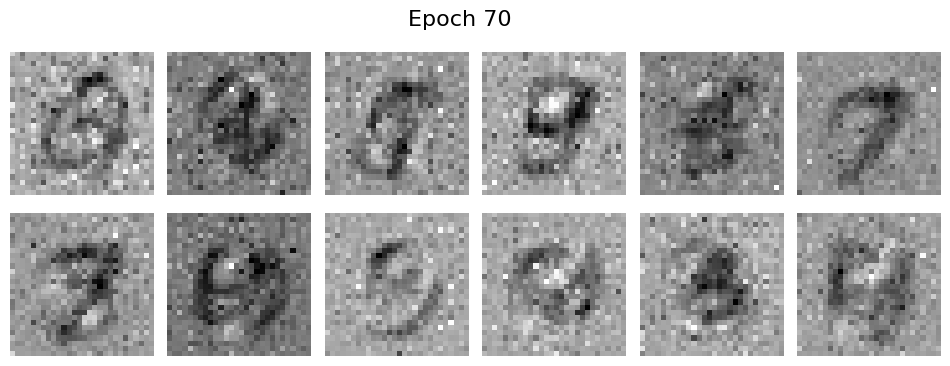

100%|██████████| 469/469 [00:20<00:00, 23.02it/s]


Epoch 71/100 | Mean NLL (Loss): -2356.8478


100%|██████████| 469/469 [00:20<00:00, 22.98it/s]


Epoch 72/100 | Mean NLL (Loss): -2356.8536


100%|██████████| 469/469 [00:20<00:00, 22.82it/s]


Epoch 73/100 | Mean NLL (Loss): -2356.8588


100%|██████████| 469/469 [00:20<00:00, 22.83it/s]


Epoch 74/100 | Mean NLL (Loss): -2356.8585


100%|██████████| 469/469 [00:20<00:00, 22.88it/s]


Epoch 75/100 | Mean NLL (Loss): -2356.8657


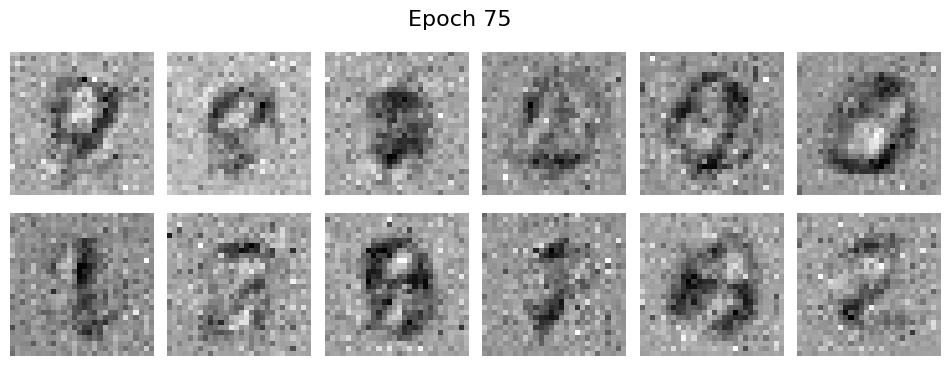

100%|██████████| 469/469 [00:20<00:00, 22.88it/s]


Epoch 76/100 | Mean NLL (Loss): -2356.8665


100%|██████████| 469/469 [00:20<00:00, 22.76it/s]


Epoch 77/100 | Mean NLL (Loss): -2356.8649


100%|██████████| 469/469 [00:20<00:00, 22.97it/s]


Epoch 78/100 | Mean NLL (Loss): -2356.8608


100%|██████████| 469/469 [00:20<00:00, 22.99it/s]


Epoch 79/100 | Mean NLL (Loss): -2356.8709


100%|██████████| 469/469 [00:20<00:00, 22.98it/s]


Epoch 80/100 | Mean NLL (Loss): -2356.8746


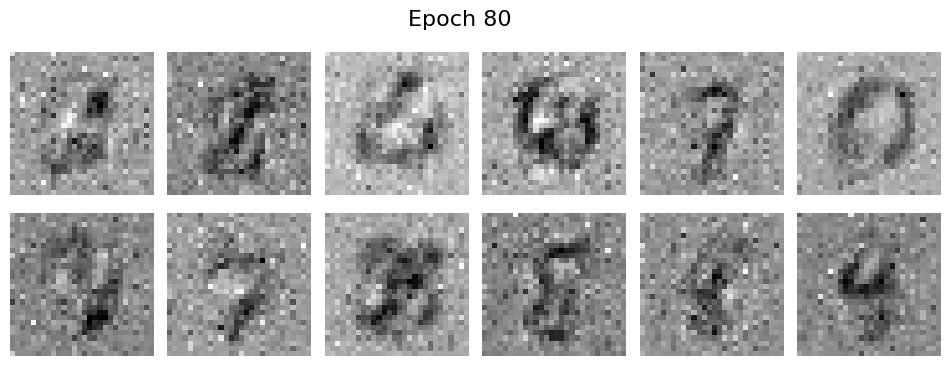

100%|██████████| 469/469 [00:20<00:00, 22.92it/s]


Epoch 81/100 | Mean NLL (Loss): -2356.8767


100%|██████████| 469/469 [00:20<00:00, 23.23it/s]


Epoch 82/100 | Mean NLL (Loss): -2356.8727


100%|██████████| 469/469 [00:19<00:00, 23.78it/s]


Epoch 83/100 | Mean NLL (Loss): -2356.8738


100%|██████████| 469/469 [00:19<00:00, 23.78it/s]


Epoch 84/100 | Mean NLL (Loss): -2356.8806


100%|██████████| 469/469 [00:20<00:00, 22.77it/s]


Epoch 85/100 | Mean NLL (Loss): -2356.8778


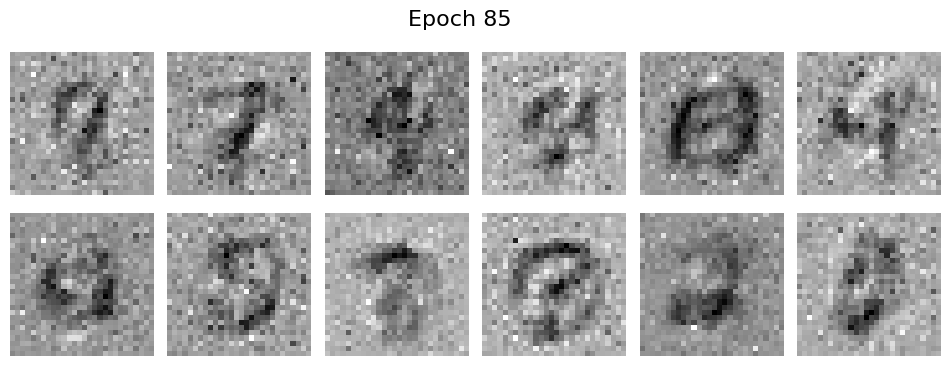

100%|██████████| 469/469 [00:20<00:00, 22.94it/s]


Epoch 86/100 | Mean NLL (Loss): -2356.8726


100%|██████████| 469/469 [00:20<00:00, 22.93it/s]


Epoch 87/100 | Mean NLL (Loss): -2356.8814


100%|██████████| 469/469 [00:20<00:00, 22.89it/s]


Epoch 88/100 | Mean NLL (Loss): -2356.8745


100%|██████████| 469/469 [00:20<00:00, 22.92it/s]


Epoch 89/100 | Mean NLL (Loss): -2356.8760


100%|██████████| 469/469 [00:20<00:00, 22.84it/s]


Epoch 90/100 | Mean NLL (Loss): -2356.8796


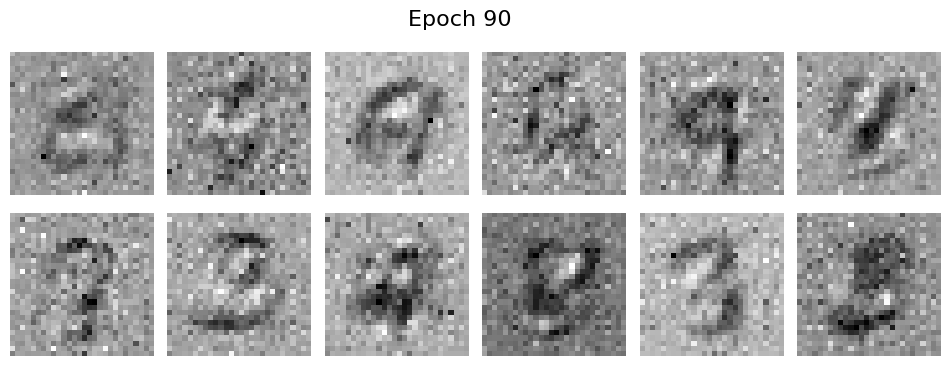

100%|██████████| 469/469 [00:20<00:00, 22.87it/s]


Epoch 91/100 | Mean NLL (Loss): -2356.8786


100%|██████████| 469/469 [00:20<00:00, 22.84it/s]


Epoch 92/100 | Mean NLL (Loss): -2356.8756


100%|██████████| 469/469 [00:20<00:00, 22.90it/s]


Epoch 93/100 | Mean NLL (Loss): -2356.8748


100%|██████████| 469/469 [00:20<00:00, 22.92it/s]


Epoch 94/100 | Mean NLL (Loss): -2356.8734


100%|██████████| 469/469 [00:20<00:00, 22.99it/s]


Epoch 95/100 | Mean NLL (Loss): -2356.8792


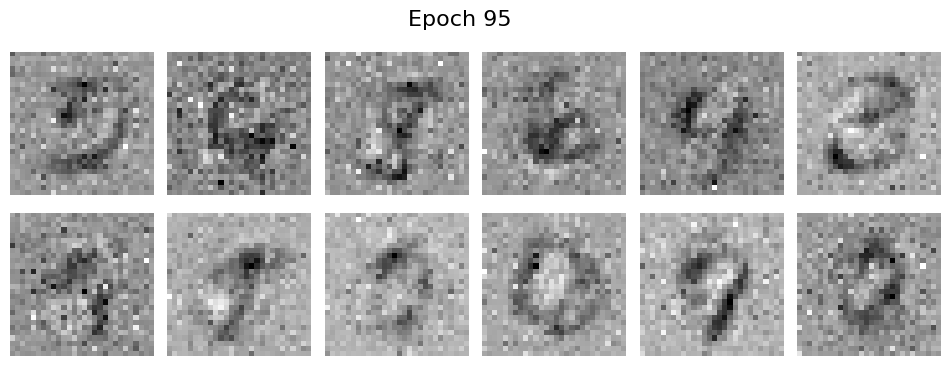

100%|██████████| 469/469 [00:20<00:00, 23.10it/s]


Epoch 96/100 | Mean NLL (Loss): -2356.8824


100%|██████████| 469/469 [00:20<00:00, 22.95it/s]


Epoch 97/100 | Mean NLL (Loss): -2356.8748


100%|██████████| 469/469 [00:20<00:00, 22.86it/s]


Epoch 98/100 | Mean NLL (Loss): -2356.8781


100%|██████████| 469/469 [00:20<00:00, 22.97it/s]


Epoch 99/100 | Mean NLL (Loss): -2356.8800


100%|██████████| 469/469 [00:20<00:00, 22.97it/s]


Epoch 100/100 | Mean NLL (Loss): -2356.8834


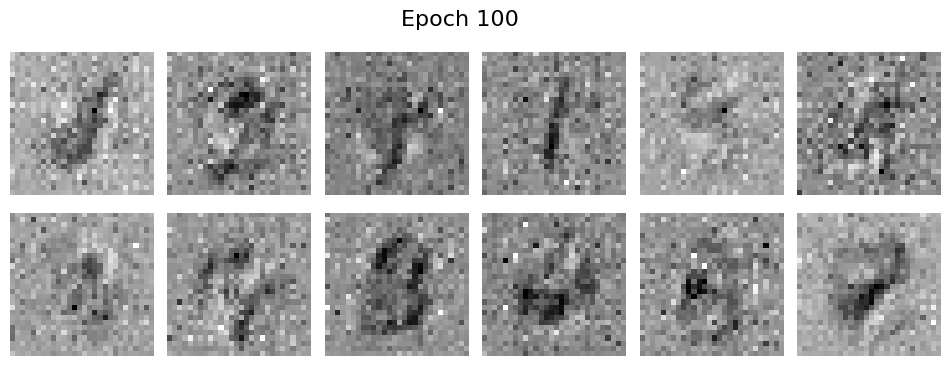

In [8]:
################################
# TRAINING FOR 5 COUPLING LAYERS
################################

# Initialization
length, height = 28, 28   # input size (MNIST)
input_dim = length * height
hidden_dim = 256      # output size of the hidden layers
num_coupling_layers = 5  # number of coupling layers
num_layers = 5        # number of linear layers for each coupling layer

epochs = 100
batch_size = 128
betas = (0.9, 0.01)
eps = 1e-4
lr = 1e-3

transform_pipeline = transforms.Compose([transforms.ToTensor(),DequantizeAndScale()])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform_pipeline)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

model = RealNVP(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    n_coupling_layers=num_coupling_layers,
    n_layers=num_layers
).to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

losses_5 = train_realnvp(model, input_dim, epochs, train_loader, lr, betas, eps, 
                         checkpoint_name = 'best_RealNVP_5.pth')

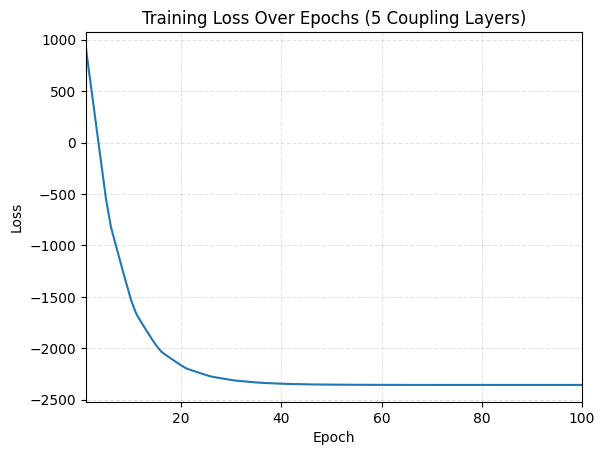

In [15]:
# Plot the Traing Loss over the Epochs
epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
plt.figure()
plt.plot(epoch_ax, losses_5)
plt.xlim([1, epochs])
plt.grid(True, linestyle='--', alpha=0.35)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs (5 Coupling Layers)")
plt.show()
plt.close()

100%|██████████| 469/469 [00:29<00:00, 15.68it/s]


Epoch 1/150 | Mean NLL (Loss): 933.2459


100%|██████████| 469/469 [00:28<00:00, 16.65it/s]


Epoch 2/150 | Mean NLL (Loss): 546.1629


100%|██████████| 469/469 [00:28<00:00, 16.72it/s]


Epoch 3/150 | Mean NLL (Loss): 179.5058


100%|██████████| 469/469 [00:28<00:00, 16.64it/s]


Epoch 4/150 | Mean NLL (Loss): -187.1376


100%|██████████| 469/469 [00:27<00:00, 16.76it/s]


Epoch 5/150 | Mean NLL (Loss): -553.6524


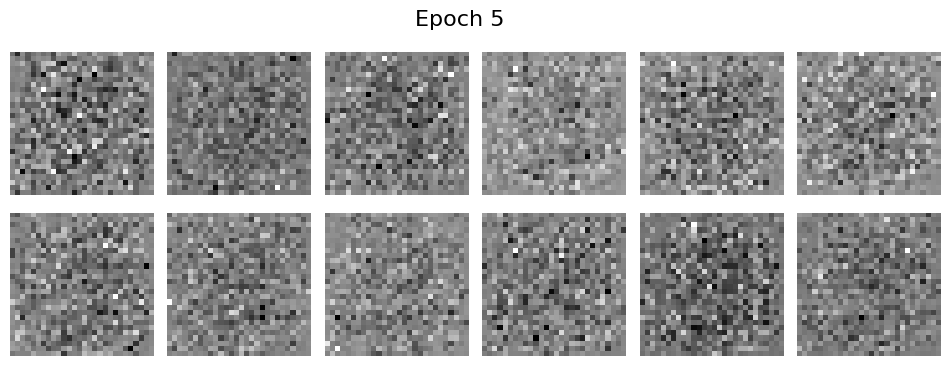

100%|██████████| 469/469 [00:27<00:00, 16.77it/s]


Epoch 6/150 | Mean NLL (Loss): -828.9950


100%|██████████| 469/469 [00:27<00:00, 16.86it/s]


Epoch 7/150 | Mean NLL (Loss): -1012.2127


100%|██████████| 469/469 [00:27<00:00, 16.85it/s]


Epoch 8/150 | Mean NLL (Loss): -1195.3920


100%|██████████| 469/469 [00:27<00:00, 16.76it/s]


Epoch 9/150 | Mean NLL (Loss): -1378.5824


100%|██████████| 469/469 [00:28<00:00, 16.66it/s]


Epoch 10/150 | Mean NLL (Loss): -1561.5951


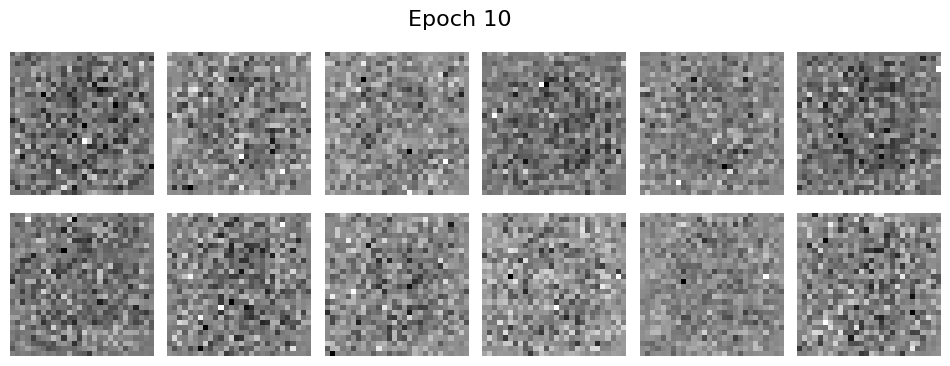

100%|██████████| 469/469 [00:28<00:00, 16.75it/s]


Epoch 11/150 | Mean NLL (Loss): -1700.1933


100%|██████████| 469/469 [00:27<00:00, 16.84it/s]


Epoch 12/150 | Mean NLL (Loss): -1791.6247


100%|██████████| 469/469 [00:28<00:00, 16.55it/s]


Epoch 13/150 | Mean NLL (Loss): -1882.8991


100%|██████████| 469/469 [00:27<00:00, 16.75it/s]


Epoch 14/150 | Mean NLL (Loss): -1973.9942


100%|██████████| 469/469 [00:28<00:00, 16.73it/s]


Epoch 15/150 | Mean NLL (Loss): -2064.8171


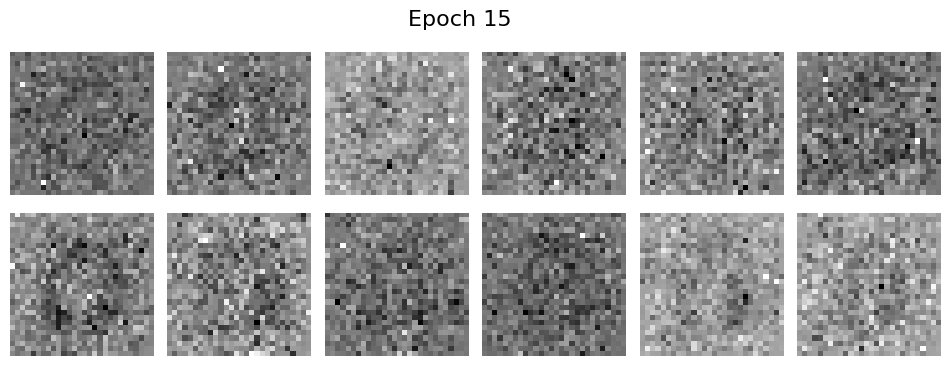

100%|██████████| 469/469 [00:27<00:00, 16.79it/s]


Epoch 16/150 | Mean NLL (Loss): -2134.2248


100%|██████████| 469/469 [00:28<00:00, 16.55it/s]


Epoch 17/150 | Mean NLL (Loss): -2179.8163


100%|██████████| 469/469 [00:28<00:00, 16.62it/s]


Epoch 18/150 | Mean NLL (Loss): -2225.3031


100%|██████████| 469/469 [00:28<00:00, 16.66it/s]


Epoch 19/150 | Mean NLL (Loss): -2270.7380


100%|██████████| 469/469 [00:27<00:00, 16.81it/s]


Epoch 20/150 | Mean NLL (Loss): -2316.0979


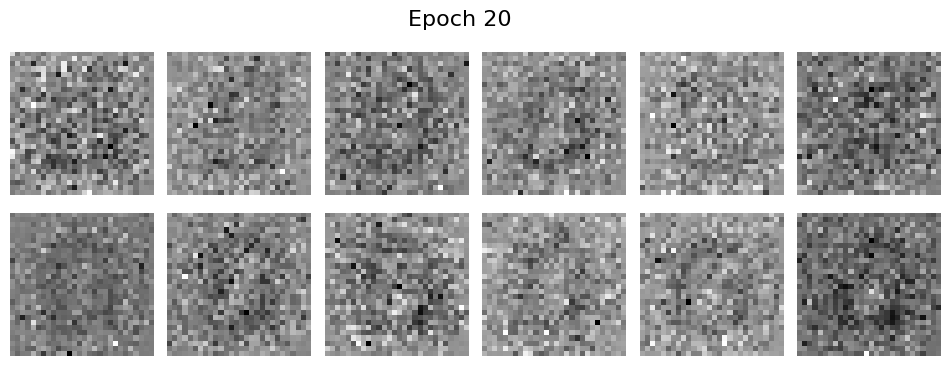

100%|██████████| 469/469 [00:27<00:00, 16.77it/s]


Epoch 21/150 | Mean NLL (Loss): -2350.7198


100%|██████████| 469/469 [00:27<00:00, 16.85it/s]


Epoch 22/150 | Mean NLL (Loss): -2373.5159


100%|██████████| 469/469 [00:26<00:00, 17.80it/s]


Epoch 23/150 | Mean NLL (Loss): -2396.2812


100%|██████████| 469/469 [00:27<00:00, 17.15it/s]


Epoch 24/150 | Mean NLL (Loss): -2419.0252


100%|██████████| 469/469 [00:27<00:00, 17.12it/s]


Epoch 25/150 | Mean NLL (Loss): -2441.7541


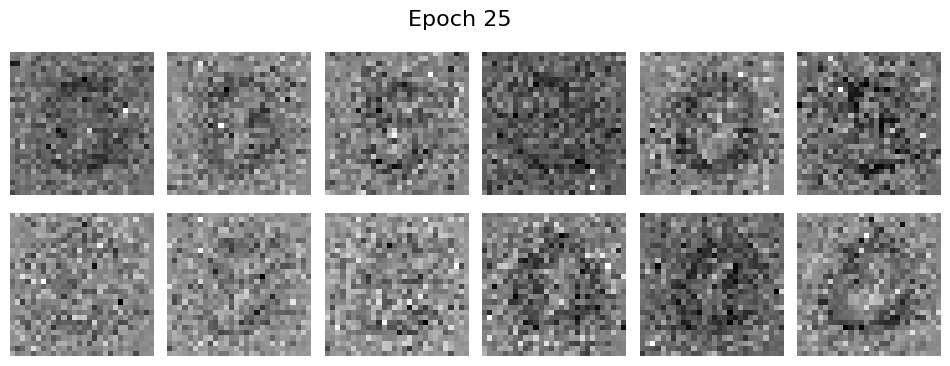

100%|██████████| 469/469 [00:27<00:00, 17.13it/s]


Epoch 26/150 | Mean NLL (Loss): -2459.0006


100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 27/150 | Mean NLL (Loss): -2470.4121


100%|██████████| 469/469 [00:27<00:00, 17.12it/s]


Epoch 28/150 | Mean NLL (Loss): -2481.8157


100%|██████████| 469/469 [00:27<00:00, 17.16it/s]


Epoch 29/150 | Mean NLL (Loss): -2493.2114


100%|██████████| 469/469 [00:27<00:00, 17.14it/s]


Epoch 30/150 | Mean NLL (Loss): -2504.6131


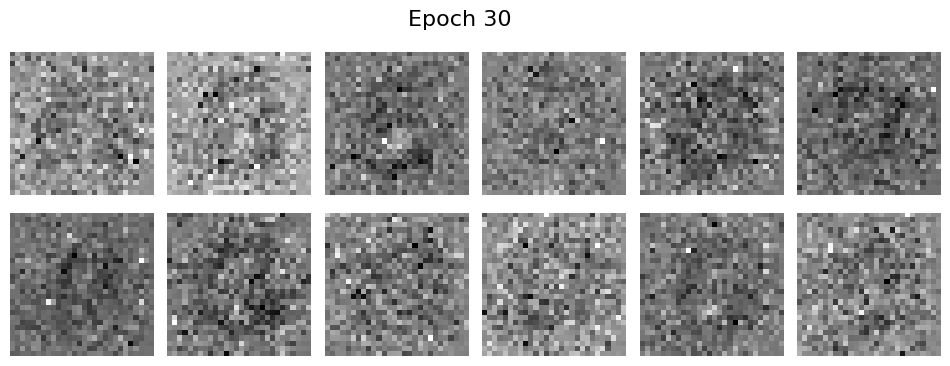

100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 31/150 | Mean NLL (Loss): -2513.2109


100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 32/150 | Mean NLL (Loss): -2518.9216


100%|██████████| 469/469 [00:27<00:00, 17.15it/s]


Epoch 33/150 | Mean NLL (Loss): -2524.6279


100%|██████████| 469/469 [00:27<00:00, 17.09it/s]


Epoch 34/150 | Mean NLL (Loss): -2530.3368


100%|██████████| 469/469 [00:27<00:00, 17.17it/s]


Epoch 35/150 | Mean NLL (Loss): -2536.0419


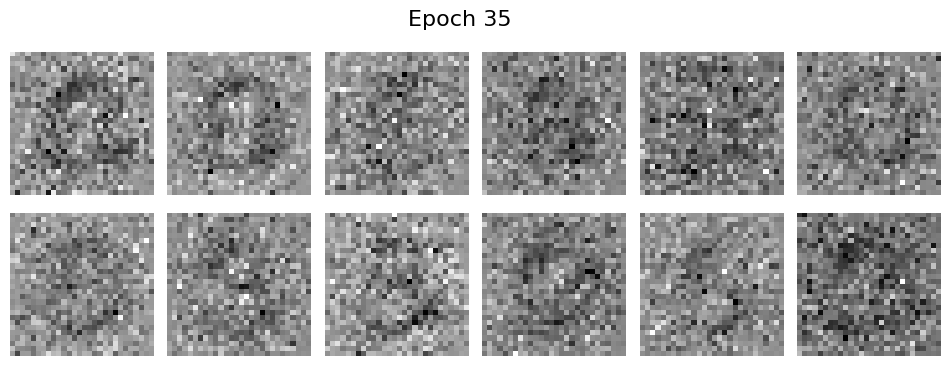

100%|██████████| 469/469 [00:27<00:00, 17.15it/s]


Epoch 36/150 | Mean NLL (Loss): -2540.3339


100%|██████████| 469/469 [00:27<00:00, 17.13it/s]


Epoch 37/150 | Mean NLL (Loss): -2543.1878


100%|██████████| 469/469 [00:27<00:00, 17.13it/s]


Epoch 38/150 | Mean NLL (Loss): -2546.0396


100%|██████████| 469/469 [00:27<00:00, 17.14it/s]


Epoch 39/150 | Mean NLL (Loss): -2548.8902


100%|██████████| 469/469 [00:27<00:00, 17.16it/s]


Epoch 40/150 | Mean NLL (Loss): -2551.7406


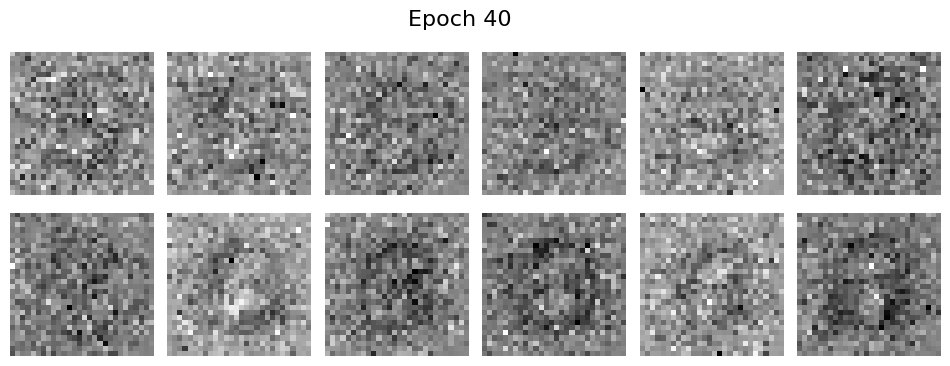

100%|██████████| 469/469 [00:27<00:00, 17.16it/s]


Epoch 41/150 | Mean NLL (Loss): -2553.8748


100%|██████████| 469/469 [00:27<00:00, 17.12it/s]


Epoch 42/150 | Mean NLL (Loss): -2555.2841


100%|██████████| 469/469 [00:27<00:00, 17.16it/s]


Epoch 43/150 | Mean NLL (Loss): -2556.6941


100%|██████████| 469/469 [00:27<00:00, 17.12it/s]


Epoch 44/150 | Mean NLL (Loss): -2558.0995


100%|██████████| 469/469 [00:27<00:00, 17.15it/s]


Epoch 45/150 | Mean NLL (Loss): -2559.5057


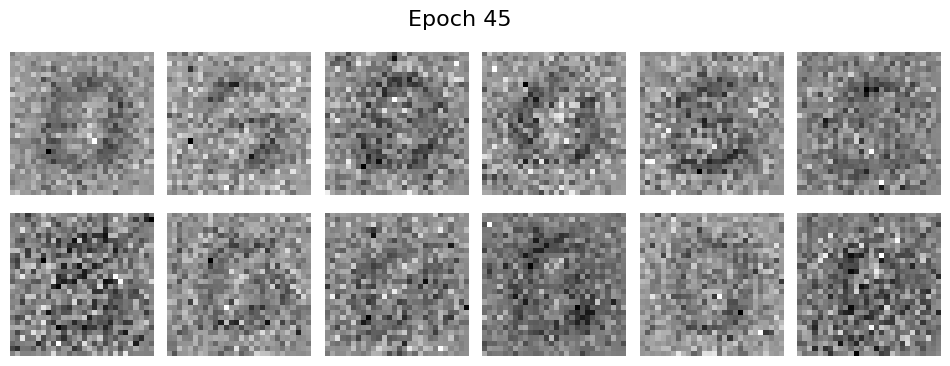

100%|██████████| 469/469 [00:27<00:00, 17.13it/s]


Epoch 46/150 | Mean NLL (Loss): -2560.5614


100%|██████████| 469/469 [00:27<00:00, 17.15it/s]


Epoch 47/150 | Mean NLL (Loss): -2561.2608


100%|██████████| 469/469 [00:27<00:00, 17.13it/s]


Epoch 48/150 | Mean NLL (Loss): -2561.9599


100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 49/150 | Mean NLL (Loss): -2562.6591


100%|██████████| 469/469 [00:27<00:00, 17.21it/s]


Epoch 50/150 | Mean NLL (Loss): -2563.3584


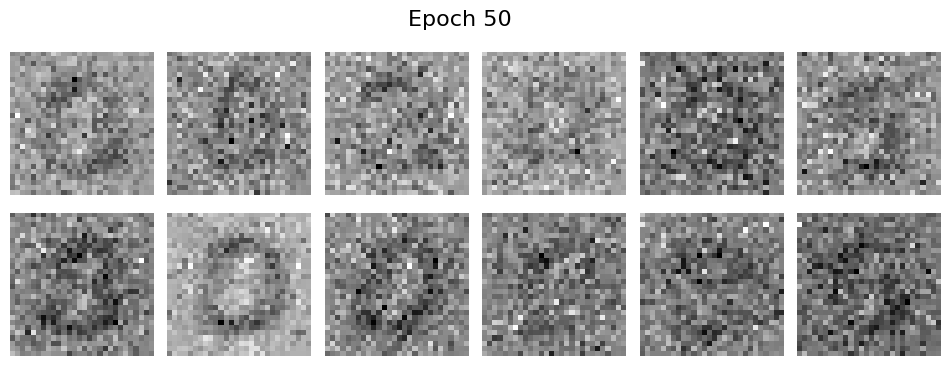

100%|██████████| 469/469 [00:27<00:00, 17.16it/s]


Epoch 51/150 | Mean NLL (Loss): -2563.8837


100%|██████████| 469/469 [00:27<00:00, 17.15it/s]


Epoch 52/150 | Mean NLL (Loss): -2564.2334


100%|██████████| 469/469 [00:27<00:00, 17.20it/s]


Epoch 53/150 | Mean NLL (Loss): -2564.5830


100%|██████████| 469/469 [00:30<00:00, 15.28it/s]


Epoch 54/150 | Mean NLL (Loss): -2564.9325


100%|██████████| 469/469 [00:27<00:00, 16.85it/s]


Epoch 55/150 | Mean NLL (Loss): -2565.2820


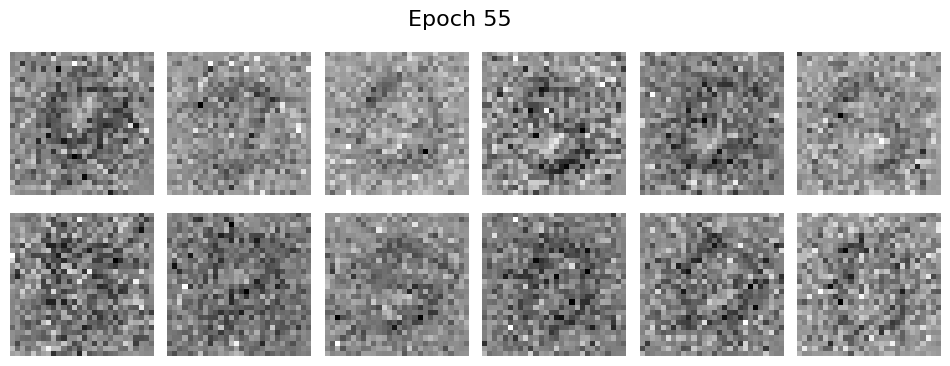

100%|██████████| 469/469 [00:27<00:00, 16.75it/s]


Epoch 56/150 | Mean NLL (Loss): -2565.5447


100%|██████████| 469/469 [00:27<00:00, 16.83it/s]


Epoch 57/150 | Mean NLL (Loss): -2565.7194


100%|██████████| 469/469 [00:27<00:00, 16.80it/s]


Epoch 58/150 | Mean NLL (Loss): -2565.8943


100%|██████████| 469/469 [00:27<00:00, 16.91it/s]


Epoch 59/150 | Mean NLL (Loss): -2566.0690


100%|██████████| 469/469 [00:28<00:00, 16.69it/s]


Epoch 60/150 | Mean NLL (Loss): -2566.2439


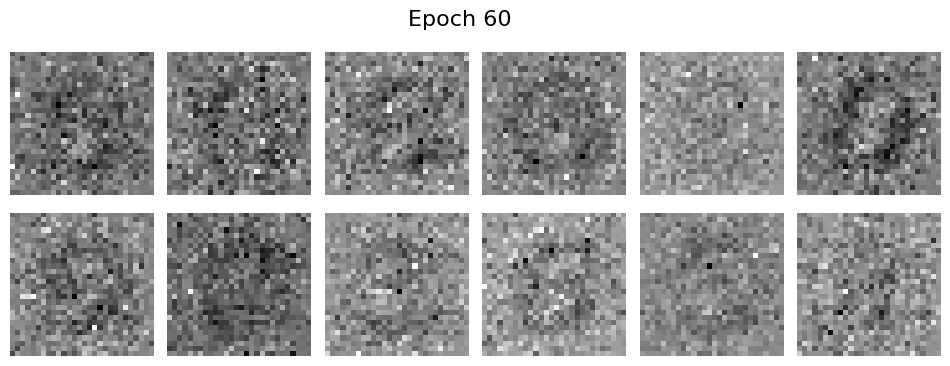

100%|██████████| 469/469 [00:27<00:00, 16.82it/s]


Epoch 61/150 | Mean NLL (Loss): -2566.4030


100%|██████████| 469/469 [00:27<00:00, 16.81it/s]


Epoch 62/150 | Mean NLL (Loss): -2566.5469


100%|██████████| 469/469 [00:27<00:00, 16.79it/s]


Epoch 63/150 | Mean NLL (Loss): -2566.6901


100%|██████████| 469/469 [00:28<00:00, 16.74it/s]


Epoch 64/150 | Mean NLL (Loss): -2566.8328


100%|██████████| 469/469 [00:27<00:00, 16.82it/s]


Epoch 65/150 | Mean NLL (Loss): -2566.9756


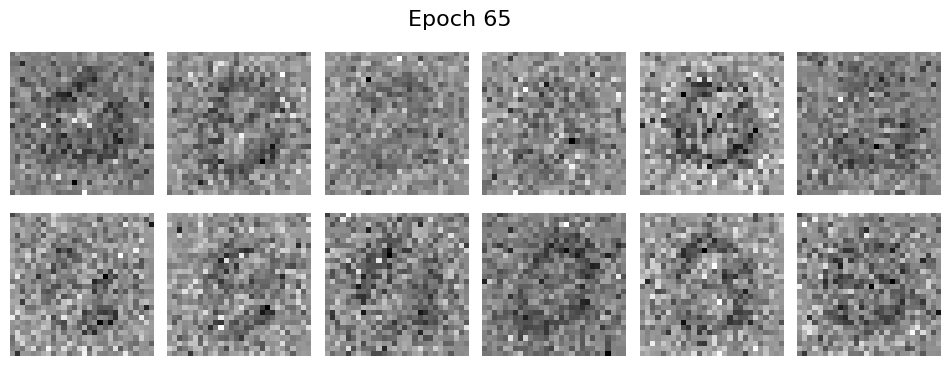

100%|██████████| 469/469 [00:27<00:00, 16.79it/s]


Epoch 66/150 | Mean NLL (Loss): -2567.0464


100%|██████████| 469/469 [00:28<00:00, 16.70it/s]


Epoch 67/150 | Mean NLL (Loss): -2567.0466


100%|██████████| 469/469 [00:27<00:00, 16.89it/s]


Epoch 68/150 | Mean NLL (Loss): -2567.0470


100%|██████████| 469/469 [00:27<00:00, 16.86it/s]


Epoch 69/150 | Mean NLL (Loss): -2567.0472


100%|██████████| 469/469 [00:27<00:00, 16.82it/s]


Epoch 70/150 | Mean NLL (Loss): -2567.0476


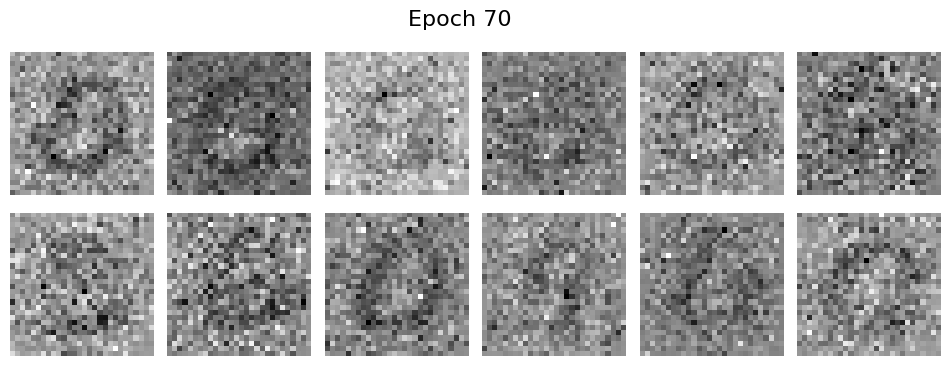

100%|██████████| 469/469 [00:28<00:00, 16.74it/s]


Epoch 71/150 | Mean NLL (Loss): -2567.0479


100%|██████████| 469/469 [00:28<00:00, 16.72it/s]


Epoch 72/150 | Mean NLL (Loss): -2567.0479


100%|██████████| 469/469 [00:28<00:00, 16.73it/s]


Epoch 73/150 | Mean NLL (Loss): -2567.0480


100%|██████████| 469/469 [00:27<00:00, 16.84it/s]


Epoch 74/150 | Mean NLL (Loss): -2567.0482


100%|██████████| 469/469 [00:28<00:00, 16.63it/s]


Epoch 75/150 | Mean NLL (Loss): -2567.0484


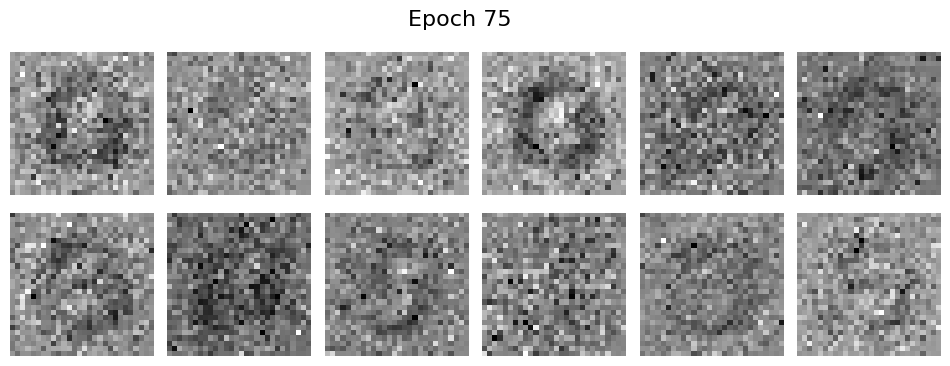

100%|██████████| 469/469 [00:27<00:00, 17.15it/s]


Epoch 76/150 | Mean NLL (Loss): -2567.0483


100%|██████████| 469/469 [00:27<00:00, 17.24it/s]


Epoch 77/150 | Mean NLL (Loss): -2567.0485


100%|██████████| 469/469 [00:27<00:00, 17.25it/s]


Epoch 78/150 | Mean NLL (Loss): -2567.0486


100%|██████████| 469/469 [00:27<00:00, 17.20it/s]


Epoch 79/150 | Mean NLL (Loss): -2567.0486


100%|██████████| 469/469 [00:27<00:00, 17.21it/s]


Epoch 80/150 | Mean NLL (Loss): -2567.0487


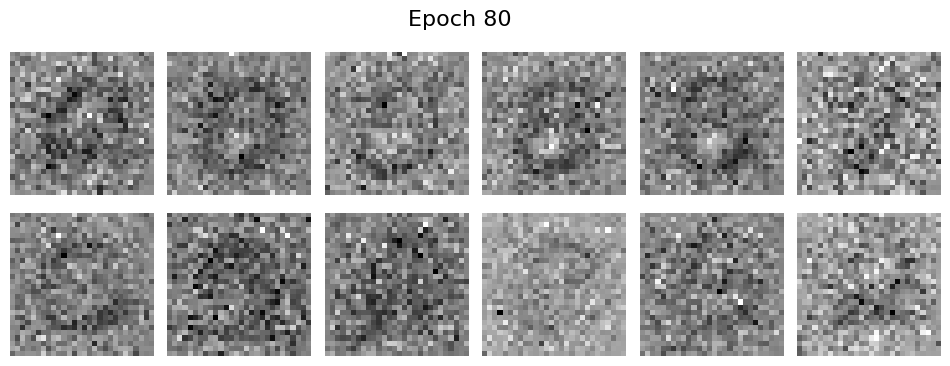

100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 81/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 82/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:27<00:00, 17.15it/s]


Epoch 83/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 84/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:27<00:00, 17.19it/s]


Epoch 85/150 | Mean NLL (Loss): -2567.0489


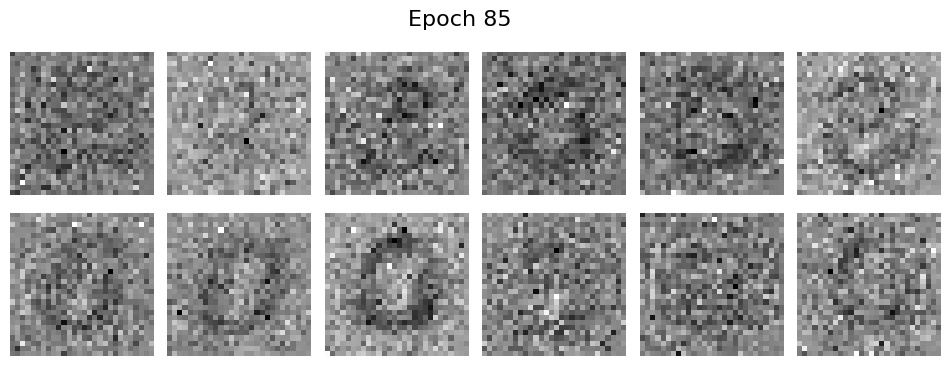

100%|██████████| 469/469 [00:27<00:00, 17.19it/s]


Epoch 86/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:27<00:00, 17.21it/s]


Epoch 87/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:27<00:00, 17.20it/s]


Epoch 88/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 17.15it/s]


Epoch 89/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:27<00:00, 17.20it/s]


Epoch 90/150 | Mean NLL (Loss): -2567.0488


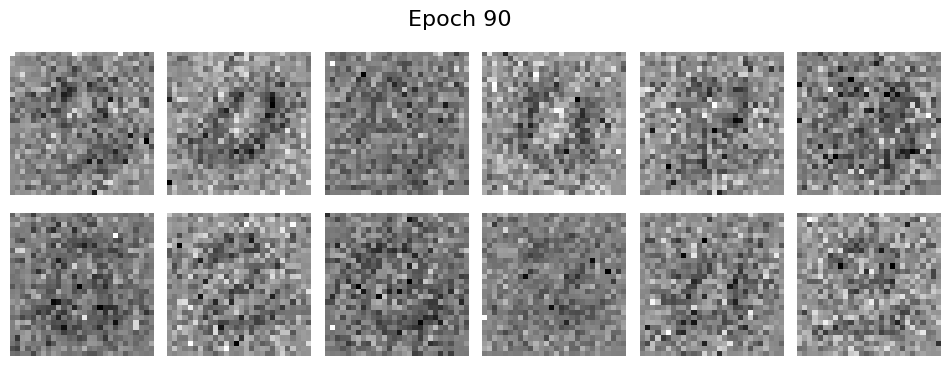

100%|██████████| 469/469 [00:27<00:00, 17.19it/s]


Epoch 91/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 92/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:27<00:00, 17.17it/s]


Epoch 93/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:27<00:00, 17.13it/s]


Epoch 94/150 | Mean NLL (Loss): -2567.0490


100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 95/150 | Mean NLL (Loss): -2567.0490


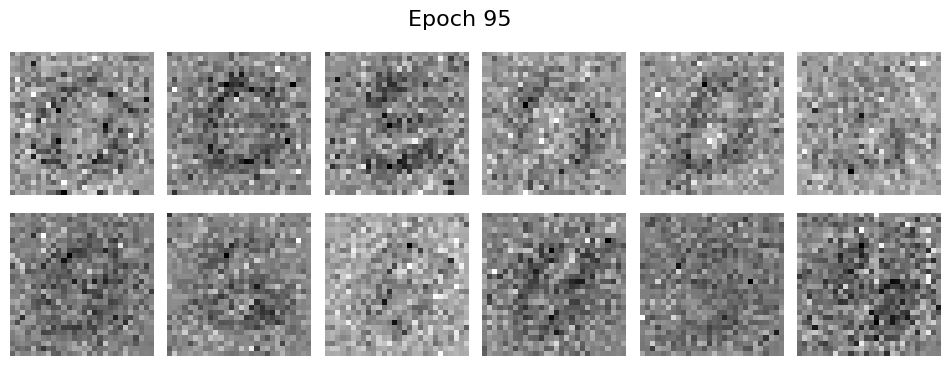

100%|██████████| 469/469 [00:27<00:00, 17.17it/s]


Epoch 96/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 17.17it/s]


Epoch 97/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 98/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 17.18it/s]


Epoch 99/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:27<00:00, 17.11it/s]


Epoch 100/150 | Mean NLL (Loss): -2567.0489


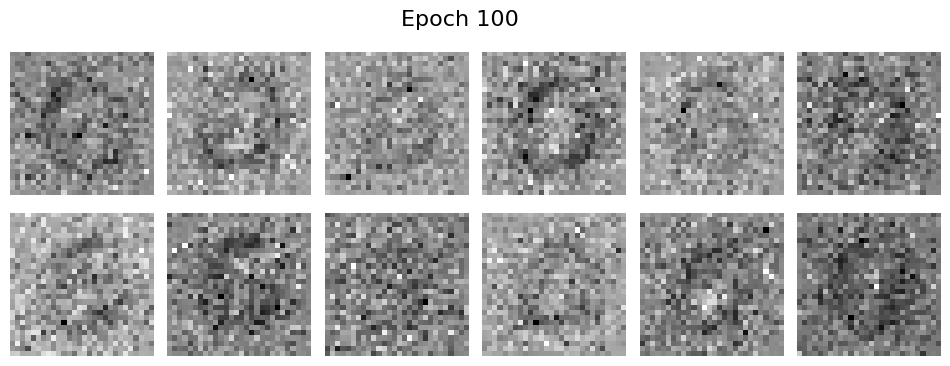

100%|██████████| 469/469 [00:27<00:00, 17.16it/s]


Epoch 101/150 | Mean NLL (Loss): -2567.0490


100%|██████████| 469/469 [00:27<00:00, 17.19it/s]


Epoch 102/150 | Mean NLL (Loss): -2567.0490


100%|██████████| 469/469 [00:27<00:00, 17.16it/s]


Epoch 103/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 17.21it/s]


Epoch 104/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 17.17it/s]


Epoch 105/150 | Mean NLL (Loss): -2567.0489


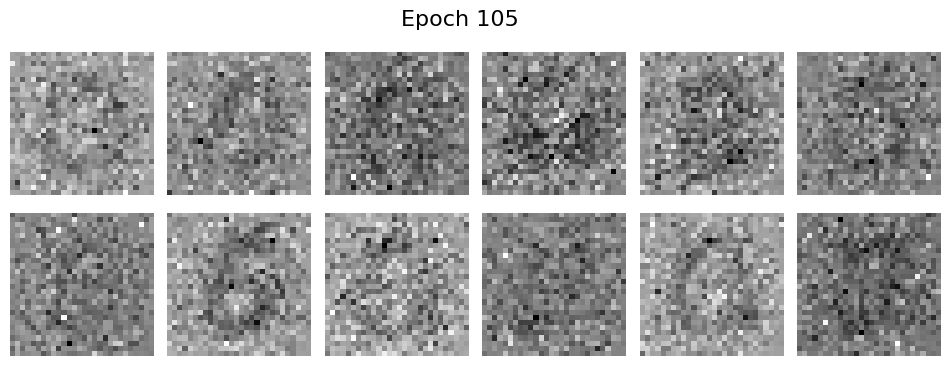

100%|██████████| 469/469 [00:27<00:00, 17.19it/s]


Epoch 106/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:27<00:00, 17.20it/s]


Epoch 107/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 17.20it/s]


Epoch 108/150 | Mean NLL (Loss): -2567.0490


100%|██████████| 469/469 [00:27<00:00, 17.19it/s]


Epoch 109/150 | Mean NLL (Loss): -2567.0491


100%|██████████| 469/469 [00:27<00:00, 17.17it/s]


Epoch 110/150 | Mean NLL (Loss): -2567.0489


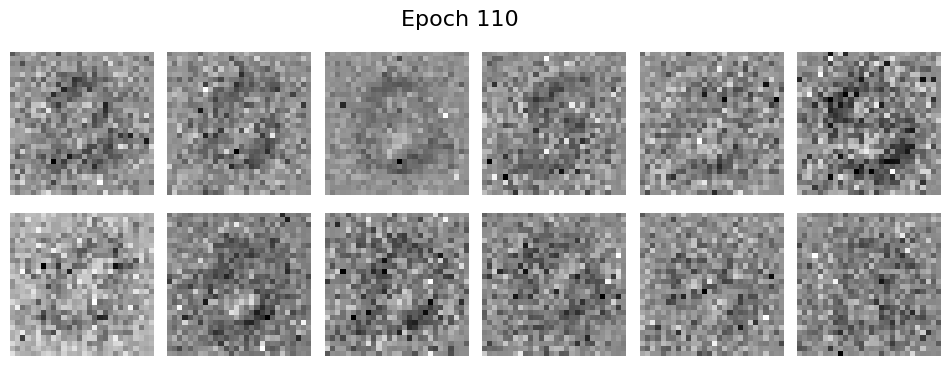

100%|██████████| 469/469 [00:27<00:00, 17.13it/s]


Epoch 111/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:28<00:00, 16.55it/s]


Epoch 112/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:31<00:00, 14.74it/s]


Epoch 113/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:31<00:00, 14.77it/s]


Epoch 114/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:31<00:00, 14.81it/s]


Epoch 115/150 | Mean NLL (Loss): -2567.0489


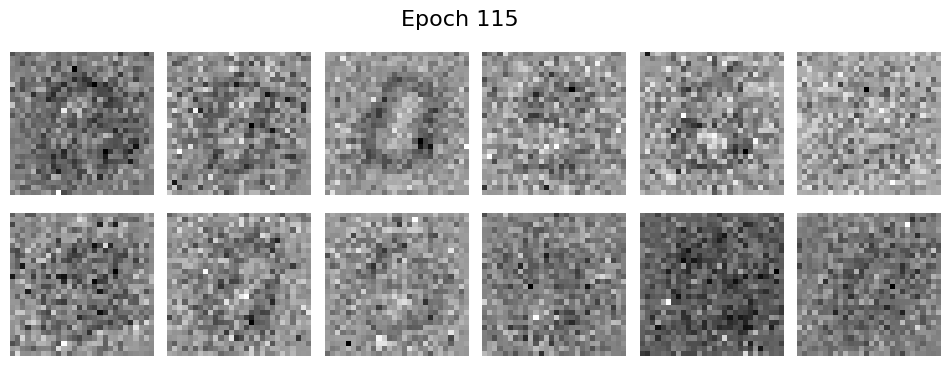

100%|██████████| 469/469 [00:28<00:00, 16.47it/s]


Epoch 116/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:30<00:00, 15.17it/s]


Epoch 117/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:30<00:00, 15.22it/s]


Epoch 118/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:30<00:00, 15.46it/s]


Epoch 119/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 16.80it/s]


Epoch 120/150 | Mean NLL (Loss): -2567.0489


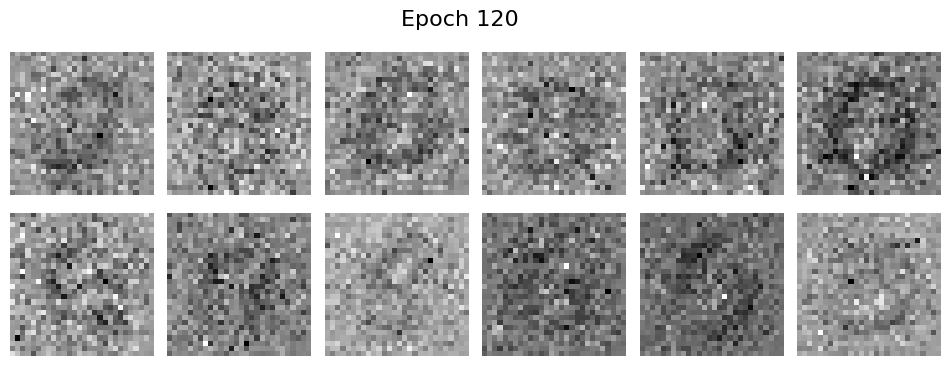

100%|██████████| 469/469 [00:27<00:00, 16.88it/s]


Epoch 121/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 16.92it/s]


Epoch 122/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 16.87it/s]


Epoch 123/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:27<00:00, 16.80it/s]


Epoch 124/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:28<00:00, 16.69it/s]


Epoch 125/150 | Mean NLL (Loss): -2567.0489


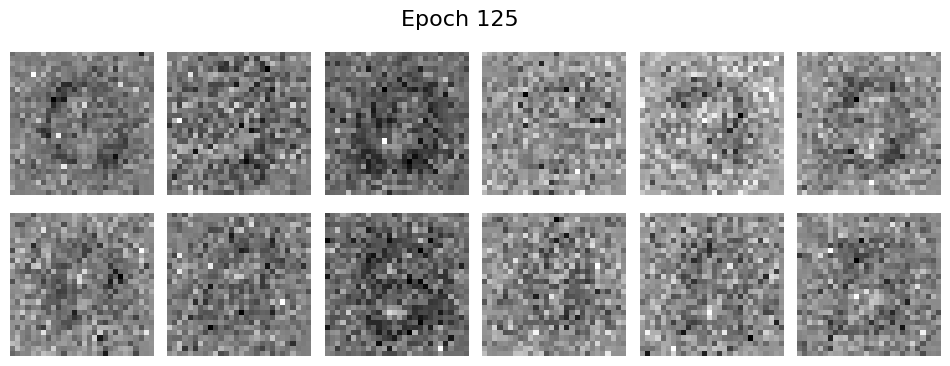

100%|██████████| 469/469 [00:27<00:00, 16.91it/s]


Epoch 126/150 | Mean NLL (Loss): -2567.0490


100%|██████████| 469/469 [00:27<00:00, 16.91it/s]


Epoch 127/150 | Mean NLL (Loss): -2567.0490


100%|██████████| 469/469 [00:28<00:00, 16.69it/s]


Epoch 128/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 16.83it/s]


Epoch 129/150 | Mean NLL (Loss): -2567.0490


100%|██████████| 469/469 [00:27<00:00, 16.85it/s]


Epoch 130/150 | Mean NLL (Loss): -2567.0490


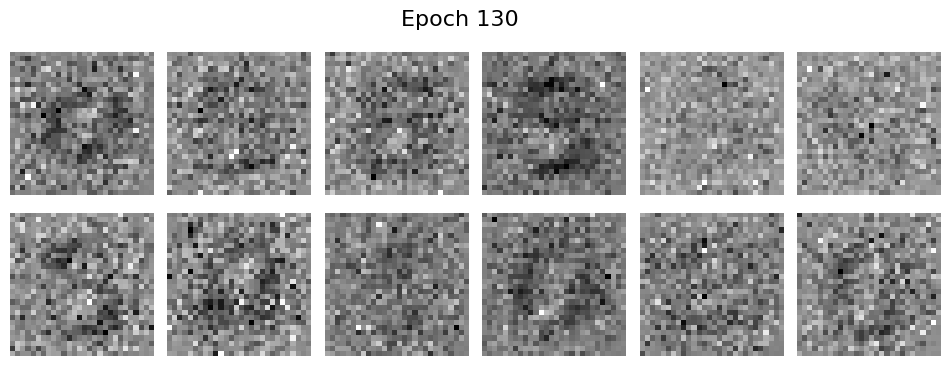

100%|██████████| 469/469 [00:27<00:00, 16.75it/s]


Epoch 131/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 16.77it/s]


Epoch 132/150 | Mean NLL (Loss): -2567.0490


100%|██████████| 469/469 [00:28<00:00, 16.58it/s]


Epoch 133/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:28<00:00, 16.72it/s]


Epoch 134/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 16.91it/s]


Epoch 135/150 | Mean NLL (Loss): -2567.0489


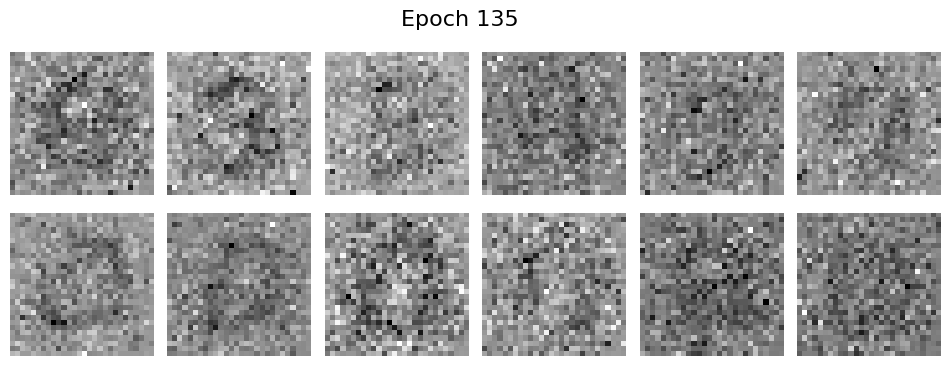

100%|██████████| 469/469 [00:27<00:00, 16.82it/s]


Epoch 136/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:28<00:00, 16.68it/s]


Epoch 137/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:27<00:00, 17.04it/s]


Epoch 138/150 | Mean NLL (Loss): -2567.0490


100%|██████████| 469/469 [00:31<00:00, 14.94it/s]


Epoch 139/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:31<00:00, 14.95it/s]


Epoch 140/150 | Mean NLL (Loss): -2567.0489


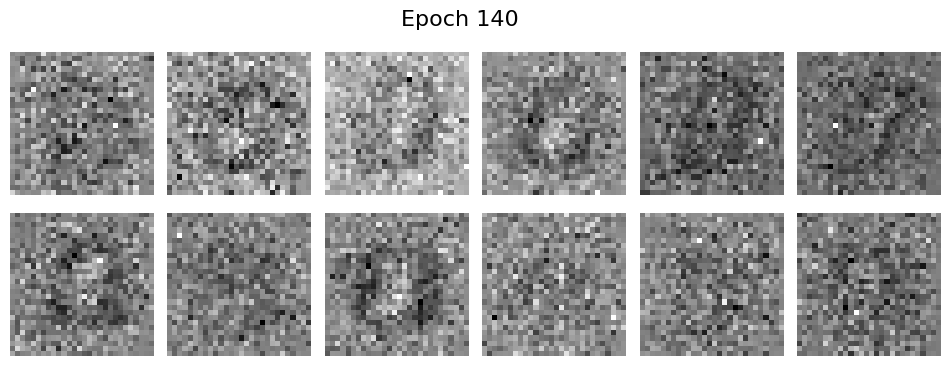

100%|██████████| 469/469 [00:31<00:00, 14.92it/s]


Epoch 141/150 | Mean NLL (Loss): -2567.0490


100%|██████████| 469/469 [00:31<00:00, 14.95it/s]


Epoch 142/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:31<00:00, 14.94it/s]


Epoch 143/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:31<00:00, 14.93it/s]


Epoch 144/150 | Mean NLL (Loss): -2567.0489


100%|██████████| 469/469 [00:31<00:00, 14.90it/s]


Epoch 145/150 | Mean NLL (Loss): -2567.0490


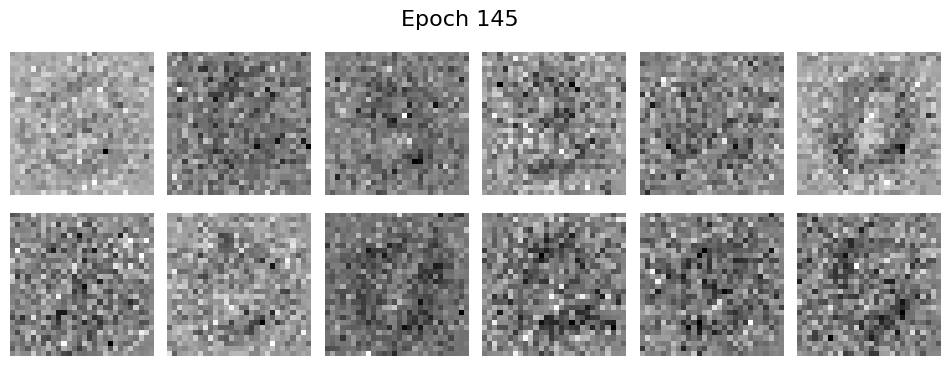

100%|██████████| 469/469 [00:31<00:00, 14.91it/s]


Epoch 146/150 | Mean NLL (Loss): -2567.0490


100%|██████████| 469/469 [00:31<00:00, 14.91it/s]


Epoch 147/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:30<00:00, 15.41it/s]


Epoch 148/150 | Mean NLL (Loss): -2567.0488


100%|██████████| 469/469 [00:30<00:00, 15.26it/s]


Epoch 149/150 | Mean NLL (Loss): -2567.0490


100%|██████████| 469/469 [00:30<00:00, 15.36it/s]


Epoch 150/150 | Mean NLL (Loss): -2567.0490


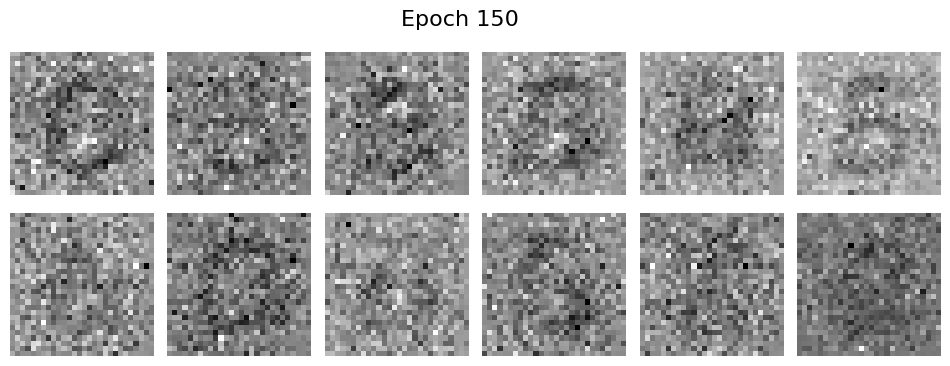

In [18]:
#################################
# TRAINING FOR 10 COUPLING LAYERS
#################################

# Initialization
length, height = 28, 28   # input size (MNIST)
input_dim = length * height
hidden_dim = 256      # output size of the hidden layers
num_coupling_layers = 10  # number of coupling layers
num_layers = 5        # number of linear layers for each coupling layer

epochs = 150
batch_size = 128
betas = (0.9, 0.01)
eps = 1e-4
lr = 1e-3

transform_pipeline = transforms.Compose([transforms.ToTensor(),DequantizeAndScale()])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform_pipeline)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

model = RealNVP(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    n_coupling_layers=num_coupling_layers,
    n_layers=num_layers
).to(device)

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

losses_10 = train_realnvp(model, input_dim, epochs, train_loader, lr, betas, eps, 
                          checkpoint_name = 'best_RealNVP_10.pth')


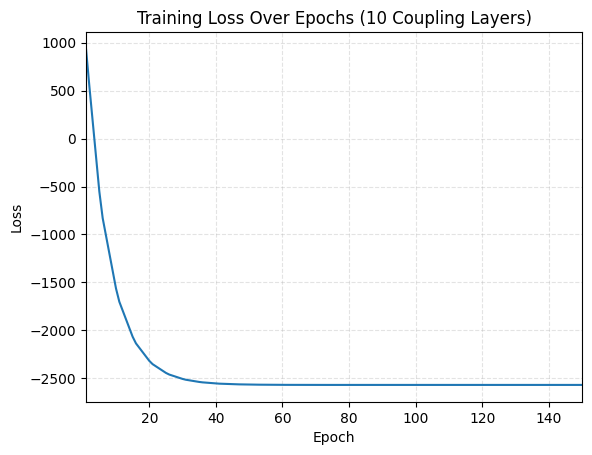

In [19]:
# Plot the Traing Loss over the Epochs
epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
plt.figure()
plt.plot(epoch_ax, losses_10)
plt.xlim([1, epochs])
plt.grid(True, linestyle='--', alpha=0.35)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs (10 Coupling Layers)")
plt.show()
plt.close()

↓ Load Saved Model (un-comment and download .pth files from MEGA link) ↓

Loaded model from epoch 100 with loss -2356.8834


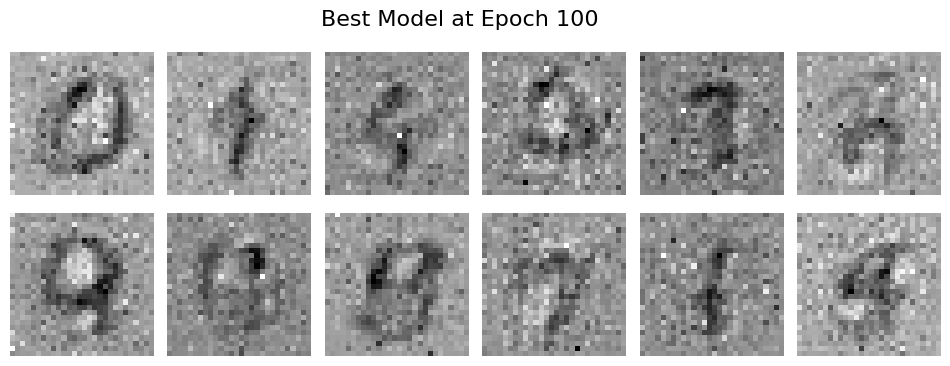

Loaded model from epoch 109 with loss -2567.0491


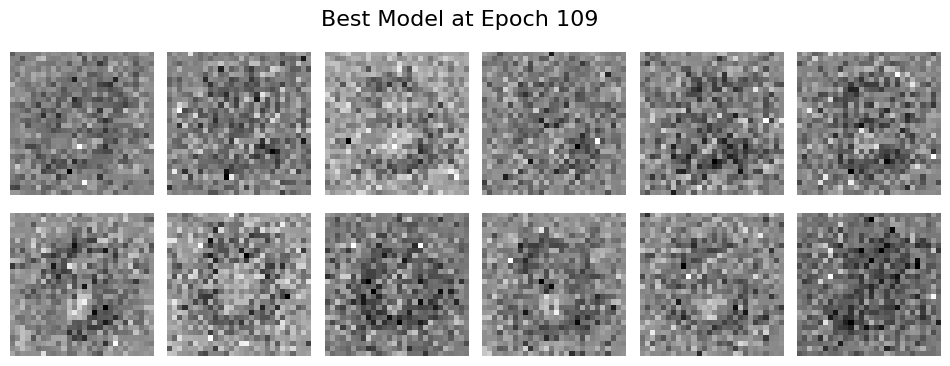

In [25]:
# # LOAD BEST_MODELS FROM CHECKPOINT .pth FILE (5 and 10 coupling layers)
# def load_model(filepath, model, optimizer=None):
#     checkpoint = tc.load(filepath)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     if optimizer:
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     epoch = checkpoint['epoch']
#     loss = checkpoint['loss']
#     print(f"Loaded model from epoch {epoch} with loss {loss:.4f}")
#     return model, optimizer, epoch, loss

# length, height = 28, 28   # input size (MNIST)
# input_dim = length * height
# hidden_dim = 256      # output size of the hidden layers
# num_coupling_layers = 5  # number of coupling layers
# num_layers = 5        # number of linear layers for each coupling layer

# epochs = 150
# batch_size = 128
# betas = (0.9, 0.01)
# eps = 1e-4
# lr = 1e-3

# model = RealNVP(
#     input_dim=input_dim,
#     hidden_dim=hidden_dim,
#     n_coupling_layers=num_coupling_layers,
#     n_layers=num_layers
# ).to(device)

# optimizer = tc.optim.Adam(params=model.parameters(), lr=lr, betas=betas, eps=eps)
# model, optimizer, epoch, loss = load_model('checkpoints/best_RealNVP_5.pth', model, optimizer)
# sample_model(model, n_samples=12, title=f"Best Model at Epoch {epoch}")

# num_coupling_layers = 10
# model = RealNVP(
#     input_dim=input_dim,
#     hidden_dim=hidden_dim,
#     n_coupling_layers=num_coupling_layers,
#     n_layers=num_layers
# ).to(device)

# optimizer = tc.optim.Adam(params=model.parameters(), lr=lr, betas=betas, eps=eps)
# model, optimizer, epoch, loss = load_model('checkpoints/best_RealNVP_10.pth', model, optimizer)
# sample_model(model, n_samples=12, title=f"Best Model at Epoch {epoch}")

---

→ (c): Perform linear and sinusoidal interpolations between two MNIST digits in the latent space

Interpolation and Plotting Functions

`linear_interpolation` : provids a straight-line transition between the vectors for each value in `lambda_vals`.<br>
`sinusoidal_interpolation` : computes a sinusoidal interpolation, offering a smoother transition compared to the linear method by using a sine function.

Random pairs of images are sampled from the dataset, and the `interpolate_and_plot` function is called for both linear and sinusoidal interpolations. <br>
This demonstrates how to visualize the transitions between images in the latent space using the trained RealNVP model. 

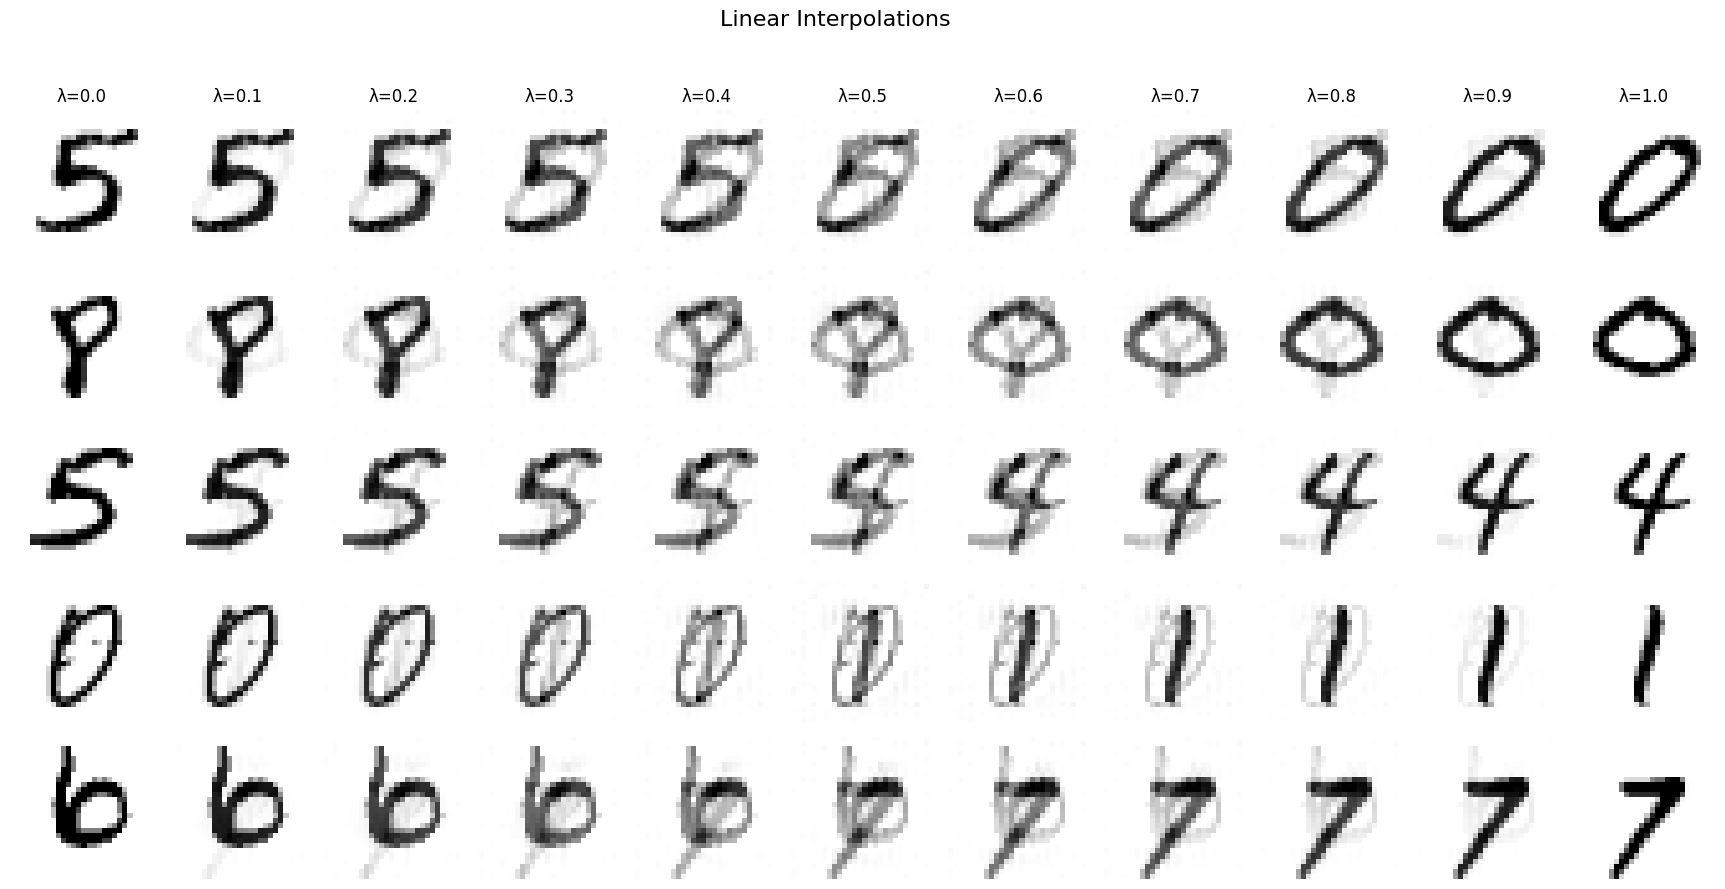

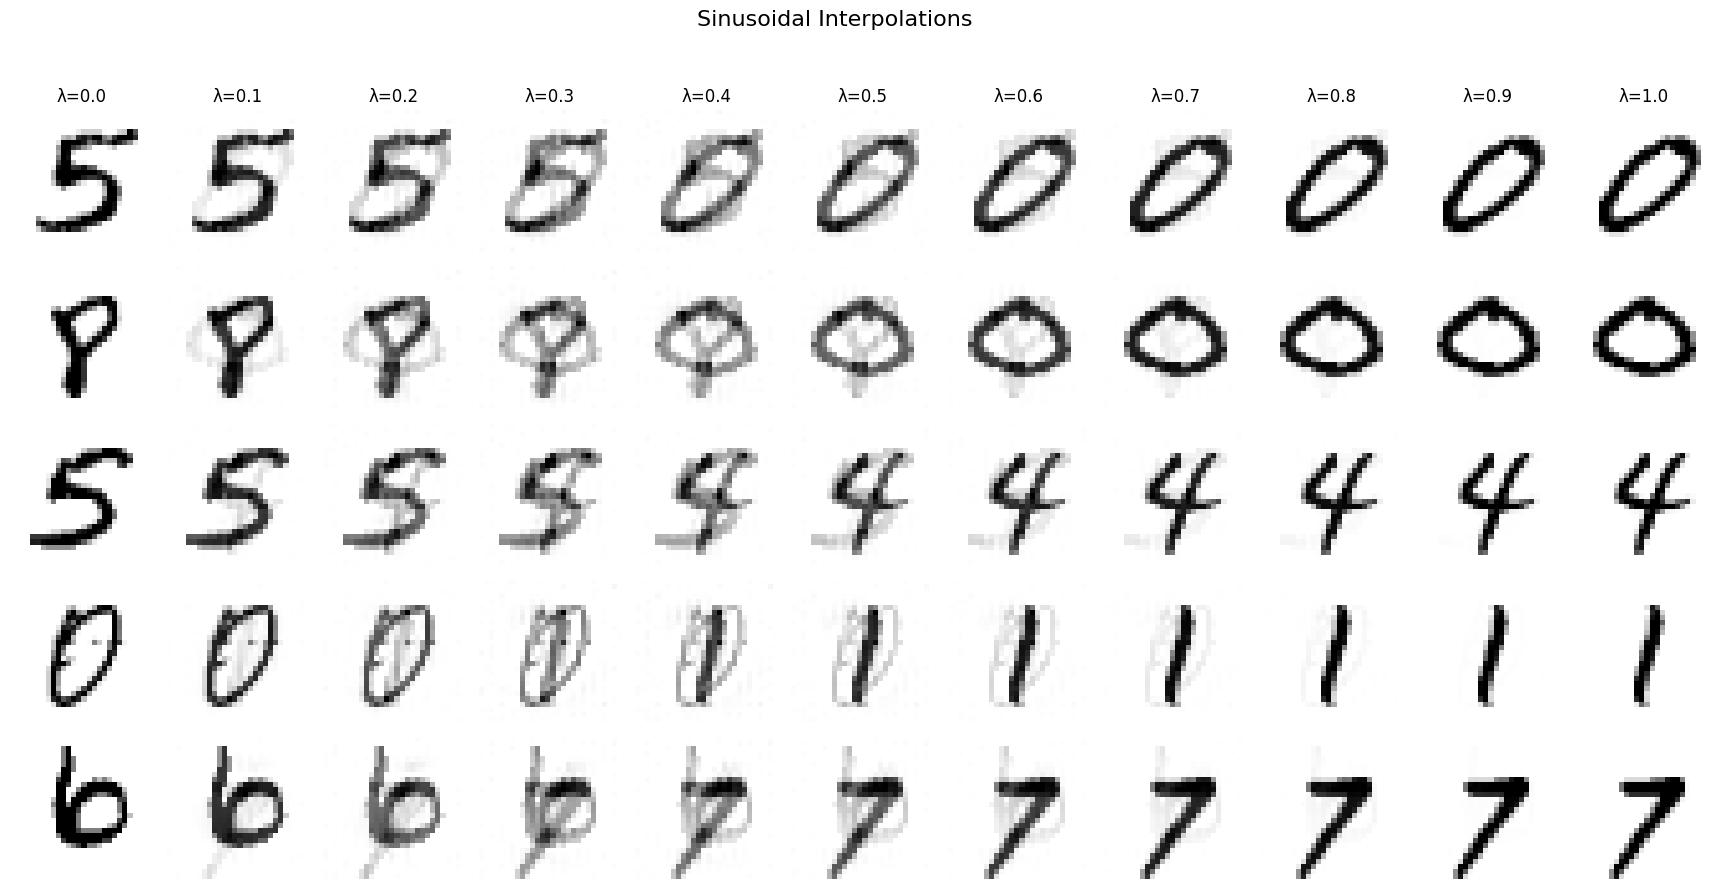

In [12]:
def linear_interpolation(z1, z2, lambda_vals):
    return [(1 - l) * z1 + l * z2 for l in lambda_vals]

def sinusoidal_interpolation(z1, z2, lambda_vals):
    return [(1 - np.sin(l * np.pi / 2)) * z1 + np.sin(l * np.pi / 2) * z2 for l in lambda_vals]


def interpolate_and_plot(model, pairs, lambda_vals, interpolation_type, threshold=0.5):
    
    model.eval()
    
    if interpolation_type == 'linear':
        interpolate = linear_interpolation
        title = 'Linear Interpolations'
    elif interpolation_type == 'sinusoidal':
        interpolate = sinusoidal_interpolation
        title = 'Sinusoidal Interpolations'

    num_pairs = len(pairs)
    fig, axs = plt.subplots(num_pairs, len(lambda_vals), figsize=(2 * len(lambda_vals), 2 * num_pairs))
    
    fig.suptitle(title, fontsize=16)
    
    for col, lamb in enumerate(lambda_vals):
        axs[0, col].set_title(f'λ={lamb:.1f}', fontsize=12)
    
    for idx, (img1, img2) in enumerate(pairs):
        # Encode images to latent space
        z1, _ = model(img1.to(device).view(-1, input_dim))
        z2, _ = model(img2.to(device).view(-1, input_dim))

        interpolations = interpolate(z1.cpu().detach().numpy(), z2.cpu().detach().numpy(), lambda_vals)
        interpolated_images = [model.inverse(tc.tensor(z).to(device))[0].cpu().detach().numpy().reshape(28, 28) for z in interpolations]

        for i, img in enumerate(interpolated_images):
            if lambda_vals[i] == 0:
                final_img = img1.cpu().detach().numpy().reshape(28, 28)
            elif lambda_vals[i] == 1:
                final_img = img2.cpu().detach().numpy().reshape(28, 28)
            else:
                # Apply threshold to emphasize prominent pixels
                final_img = np.where(img > threshold, img, 0)
            
            axs[idx, i].imshow(final_img, cmap='gray_r')  
            axs[idx, i].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1, top=0.88)
    plt.show()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
num_examples = 5
lambda_vals = np.linspace(0, 1, 11)
pairs = []

# Randomly sample 4 pairs of images from the dataset
for _ in range(num_examples):
    idx1 = np.random.randint(0, len(train_dataset))
    idx2 = np.random.randint(0, len(train_dataset))
    img1, _ = train_dataset[idx1]
    img2, _ = train_dataset[idx2]
    pairs.append((img1, img2))

# Call interpolation plotting function for linear interpolation
interpolate_and_plot(model, pairs, lambda_vals, interpolation_type='linear',threshold=0.)

# Call interpolation plotting function for sinusoidal interpolation
interpolate_and_plot(model, pairs, lambda_vals, interpolation_type='sinusoidal',threshold=0.)
